 # Прогноз оттока клиентов для компании «ТелеДом»

Оператор связи «ТелеДом» столкнулся с проблемой оттока клиентов. Чтобы удержать абонентов, компания планирует внедрить систему предложений промокодов и специальных условий для пользователей, собирающихся отказаться от услуг связи. Для успешной реализации этой стратегии необходимо заранее определять, кто из клиентов находится в группе риска.

Оператор связи «ТелеДом» предоставляет стационарную телефонную связь и интернет через DSL или оптоволоконный кабель. Среди дополнительных услуг — интернет-безопасность, техподдержка, облачное хранилище, стриминговое телевидение и каталог фильмов. Клиенты могут оплачивать услуги ежемесячно или по долгосрочным договорам на 1–2 года, с выбором удобного способа оплаты и электронного чека.

Компания предоставила нам данные, собранные из нескольких источников:
1. contract_new.csv — информация о договоре;
2. personal_new.csv — персональные данные клиентов;
3. internet_new.csv — информация об интернет-услугах;
4. phone_new.csv — информация об услугах телефонии.

**Цель работы** — разработать модель машинного обучения, способную предсказывать вероятность расторжения договора абонентом. Это позволит компании стабилизировать клиентскую базу, своевременно выявлять клиентов с высоким риском ухода, а также принимать эффективные меры для их удержания. В результате компания сможет оптимизировать финансовые показатели, повысить уровень удовлетворенности клиентов, сократить затраты на привлечение новых пользователей и укрепить свою позицию на рынке.

**Задачи проекта**:

- Проанализировать предоставленные данные, содержащие информацию о клиентах, их тарифах и подключенных услугах.
- Провести исследовательский анализ и предобработку данных, подготовить данные для обучения модели.
- Обучить несколько моделей машинного обучения, провести их оценку и выбрать наилучшую по показателям качества прогноза.
- Провести тестирование финальной модели на тестовой выборке, чтобы оценить её точность.
- Подготовить рекомендации для внедрения модели в бизнес-процессы компании «ТелеДом».

Результаты проделанной нами работы помогут оператору связи своевременно реагировать на риск оттока, повышая уровень удержания клиентов и минимизируя финансовые потери.

## Шаг 1. Загрузка данных

In [1]:
!pip install phik==0.12.4 -q
!pip install scikit-learn==1.1.3
!pip install shap -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import phik
import re
import time
import shap

from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

RANDOM_STATE = 231224
TEST_SIZE = 0.25

Для начала загрузим наши исходные датасеты

In [2]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

In [3]:
display(contract.head(5))
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
display(personal.head(5))
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [5]:
display(internet.head(5))
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [6]:
display(phone.head(5))
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Итак, мы можем заметить, что в первом наборе данных 7043 записи, что соответствует количеству клиентов. Во втором наборе данных имеется также 7043 записи. Третий набор данных содержит 5517 записей, что меньше по сравнению с первым и вторым наборами. Это может означать, что не все клиенты используют интернет-услуги. И наконец четвертый набор данных имеет 6361 запись, что также меньше, чем в первых двух, возможно из-за того, что не все клиенты подключены к телефонным линиям.

В данных нет пропусков, и далее нужно будет обратить внимание на типы данных в некоторых столбцах, таких как TotalCharges, BeginDate, EndDate и SeniorCitizen. Можно приступить к предобработке и исследовательскому анализу данных (по каждой таблице).

## Шаг 2. Исследовательский анализ и предобработка данных

Для начала приведем все названия столбцов к единому виду. Добавим нижнее подчёркивание между строчной и заглавной буквой, если заглавная не стоит в начале строки, и преобразуем все буквы в нижний регистр.

In [7]:
def format_columns(columns):
    return [re.sub(r'(?<=[a-z])(?=[A-Z])', '_', col).lower() for col in columns]

contract.columns = format_columns(contract.columns)
personal.columns = format_columns(personal.columns)
internet.columns = format_columns(internet.columns)
phone.columns = format_columns(phone.columns)

print(contract.columns)
print(personal.columns)
print(internet.columns)
print(phone.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['customer_id', 'multiple_lines'], dtype='object')


Далее выведем количество пропусков в каждом датасете

In [8]:
print(contract.isna().sum())
print(personal.isna().sum())
print(internet.isna().sum())
print(phone.isna().sum())

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64
customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64
customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64
customer_id       0
multiple_lines    0
dtype: int64


Как мы сразу можем заметить в исходных датафреймах отсутсвуют пропуски. 

Проверим во всех ли столбцах используется корректный тип данных. В признаке total_charges мы имеем тип object, поэтому требуется преобразовать данный столбец в тип float64.

In [9]:
contract['total_charges'].value_counts().sort_index()

          11
100.17     1
100.19     1
100.2      1
100.24     1
          ..
997.05     1
997.78     1
998.89     1
999.6      2
999.9      1
Name: total_charges, Length: 6658, dtype: int64

Перед преобразованием необходимо заменить пропуски в признаке total_charges на числовое значение, например, на 0, поскольку отсутствие данных в этом столбце может свидетельствовать о том, что оплата еще не была произведена.

In [10]:
contract['total_charges'] = contract['total_charges'].replace(['', ' '], 0)

In [11]:
display(contract[contract['total_charges'] == 0])

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0


Как видно из списка абонентов, эти клиенты начали пользоваться услугами компании всего лишь 1 день.

In [12]:
contract['total_charges'] = contract['total_charges'].astype('float64')

Кроме того, begin_date и end_date необходимо преобразовать в формат даты

In [13]:
unique_begin_date = sorted(contract['begin_date'].unique())
print(unique_begin_date)

['2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019

In [14]:
# Изменение типа данных поля 'begin_date'
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['begin_date'].head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: begin_date, dtype: datetime64[ns]

In [15]:
unique_end_dates = (contract['end_date'].unique())
display(unique_end_dates)

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

В столбце end_date присутствуют значения No, которые желательно заменить перед изменением типа данных. Заменим все значения "No" в end_date на дату, которая скорее всего является датой выгрузки датасета (01.02.2020). Но перед этим определимся с нашей целевой переменной.

Целевая переменная будет определена следующим образом: для договоров, действие которых завершилось (т.е. значение в столбце даты окончания не равно 'No'), установим число 1 (договор расторгнут). Для всех остальных договоров присвоим число 0 (договор активен) и также добавим этот целевой признак в таблицу.

In [16]:
contract['target'] = contract['end_date'].apply(lambda x: 1 if x != 'No' else 0)

In [17]:
display(contract.head(3))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0


In [18]:
contract['end_date'] = contract['end_date'].replace(['No'], ['2020-02-01'])

In [19]:
display(contract.head(3))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0


In [20]:
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')
contract['end_date'].head()

0   2020-02-01
1   2020-02-01
2   2020-02-01
3   2020-02-01
4   2020-02-01
Name: end_date, dtype: datetime64[ns]

Перепроверим все измененные типы данных во всех таблицах

In [21]:
print(contract.dtypes)
print(personal.dtypes)
print(internet.dtypes)
print(phone.dtypes)

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
target                        int64
dtype: object
customer_id       object
gender            object
senior_citizen     int64
partner           object
dependents        object
dtype: object
customer_id          object
internet_service     object
online_security      object
online_backup        object
device_protection    object
tech_support         object
streaming_tv         object
streaming_movies     object
dtype: object
customer_id       object
multiple_lines    object
dtype: object


Отлично, теперь можно приступить к проверке данных на дубликаты. Произведем проверку наших датасетов на наличие полных дубликатов.

In [22]:
print(contract.duplicated().sum())
print(personal.duplicated().sum())
print(internet.duplicated().sum())
print(phone.duplicated().sum())

0
0
0
0


Как мы видим, в таблицах нет полных дубликатов.   
Произведем анализ значений всех категориальных признаков

In [23]:
print(contract['type'].unique())
print(contract['type'].value_counts())

['Month-to-month' 'One year' 'Two year']
Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64


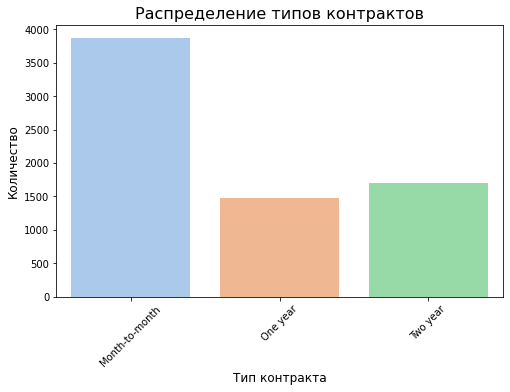

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(data=contract, x='type', palette='pastel')
plt.title('Распределение типов контрактов', fontsize=16)
plt.xlabel('Тип контракта', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Как видно из диаграммы клиенты чаще выбирают гибкие условия (Month-to-month), возможно, из-за удобства и отсутствия долгосрочных обязательств. Долгосрочные контракты (Two year и One year) менее популярны, что может указывать на необходимость дополнительной мотивации клиентов для их выбора, например, через скидки или бонусы.

In [25]:
print(contract['paperless_billing'].unique())
print(contract['paperless_billing'].value_counts())

['Yes' 'No']
Yes    4171
No     2872
Name: paperless_billing, dtype: int64


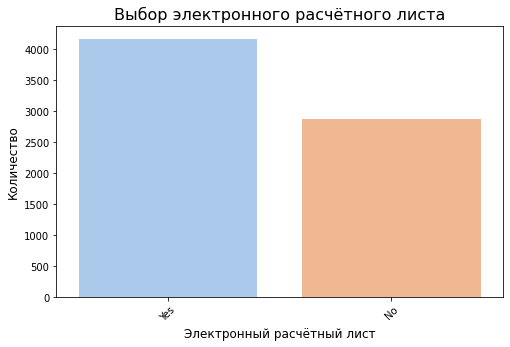

In [26]:
plt.figure(figsize=(8, 5))
sns.countplot(data=contract, x='paperless_billing', palette='pastel')
plt.title('Выбор электронного расчётного листа', fontsize=16)
plt.xlabel('Электронный расчётный лист', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Как видно из графика выше, большиство клиентов предпочитают электронные расчетные листы

In [27]:
print(contract['payment_method'].unique())
print(contract['payment_method'].value_counts())

['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64


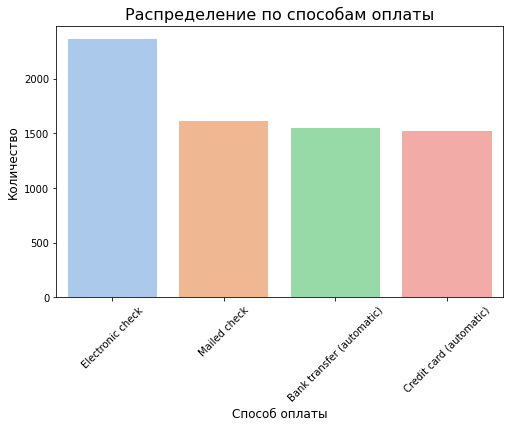

In [28]:
plt.figure(figsize=(8, 5))
sns.countplot(data=contract, x='payment_method', palette='pastel')
plt.title('Распределение по способам оплаты', fontsize=16)
plt.xlabel('Способ оплаты', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Это распределение показывает, что большинство клиентов предпочитают использовать электронные чеки для оплаты, но и почтовые чеки, автоматические переводы и оплата кредитными картами также занимают значительное место.

In [29]:
print(personal['gender'].unique())
print(personal['gender'].value_counts())

['Female' 'Male']
Male      3555
Female    3488
Name: gender, dtype: int64


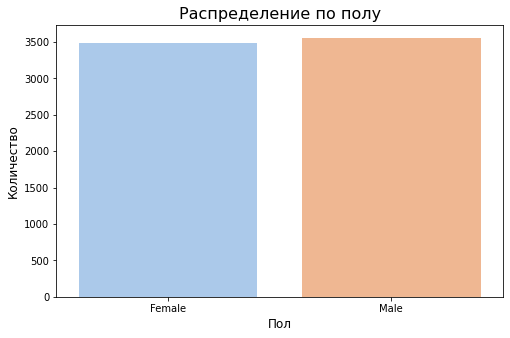

In [30]:
plt.figure(figsize=(8, 5))
sns.countplot(data=personal, x='gender', palette='pastel')
plt.title('Распределение по полу', fontsize=16)
plt.xlabel('Пол', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

На графике мы видим почти равное распределение, с небольшим преобладанием мужчин

In [31]:
print(personal['senior_citizen'].unique())
print(personal['senior_citizen'].value_counts())

[0 1]
0    5901
1    1142
Name: senior_citizen, dtype: int64


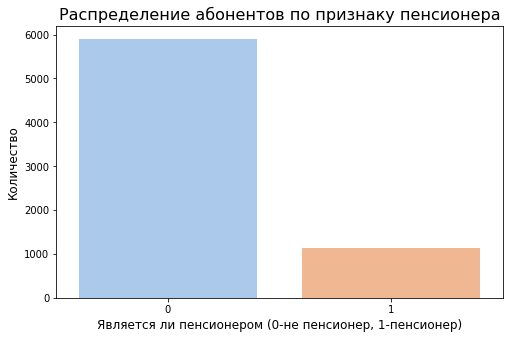

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(data=personal, x='senior_citizen', palette='pastel')
plt.title('Распределение абонентов по признаку пенсионера', fontsize=16)
plt.xlabel('Является ли пенсионером (0-не пенсионер, 1-пенсионер)', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Из данных видно, что большинство абонентов не являются пенсионерами, а пенсионеры составляют меньшую, но все же значительную часть базы клиентов (примерно 16% от общего числа абонентов).

In [33]:
print(personal['partner'].unique())
print(personal['partner'].value_counts())

['Yes' 'No']
No     3641
Yes    3402
Name: partner, dtype: int64


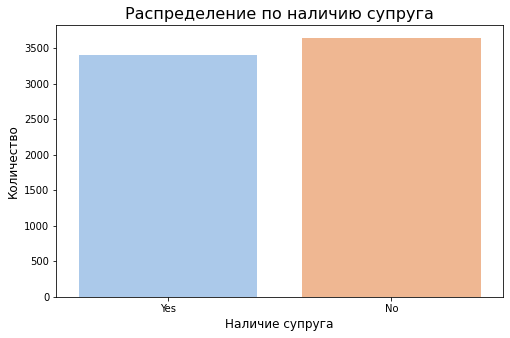

In [34]:
plt.figure(figsize=(8, 5))
sns.countplot(data=personal, x='partner', palette='pastel')
plt.title('Распределение по наличию супруга', fontsize=16)
plt.xlabel('Наличие супруга', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Из графика и данных видно, что большинство абонентов не имеют партнера, однако разница между количеством тех, кто имеет партнера, и тех, кто не имеет, не так велика. Это может быть полезно для более точного таргетинга и предложения услуг, ориентированных на семьи, например, на совместные тарифы.

In [35]:
print(personal['dependents'].unique())
print(personal['dependents'].value_counts())

['No' 'Yes']
No     4933
Yes    2110
Name: dependents, dtype: int64


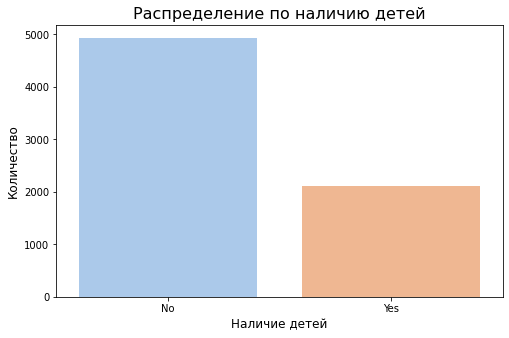

In [36]:
plt.figure(figsize=(8, 5))
sns.countplot(data=personal, x='dependents', palette='pastel')
plt.title('Распределение по наличию детей', fontsize=16)
plt.xlabel('Наличие детей', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Из этих данных можно сделать вывод, что большинство абонентов не имеют детей, однако значительное число клиентов их все же имеют.

In [37]:
print(internet['internet_service'].unique())
print(internet['internet_service'].value_counts())

['DSL' 'Fiber optic']
Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64


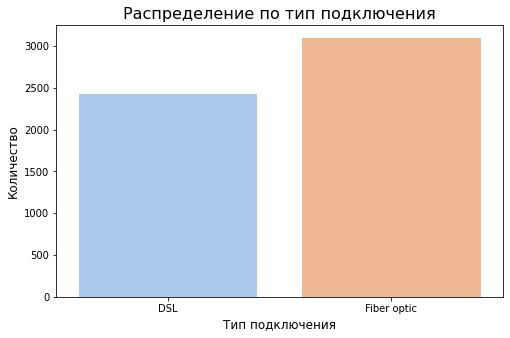

In [38]:
plt.figure(figsize=(8, 5))
sns.countplot(data=internet, x='internet_service', palette='pastel')
plt.title('Распределение по тип подключения', fontsize=16)
plt.xlabel('Тип подключения', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Большинство клиентов использует оптоволоконное подключение, что может свидетельствовать о его лучшем качестве или более широком распространении в предоставляемых услугах компании.

In [39]:
print(internet['online_security'].unique())
print(internet['online_security'].value_counts())

['No' 'Yes']
No     3498
Yes    2019
Name: online_security, dtype: int64


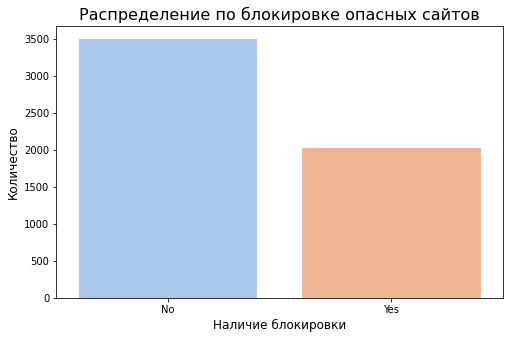

In [40]:
plt.figure(figsize=(8, 5))
sns.countplot(data=internet, x='online_security', palette='pastel')
plt.title('Распределение по блокировке опасных сайтов', fontsize=16)
plt.xlabel('Наличие блокировки', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Как мы видим из графика выше большинство клиентов оператора не активируют блокировку опасных сайтов

In [41]:
print(internet['online_backup'].unique())
print(internet['online_backup'].value_counts())

['Yes' 'No']
No     3088
Yes    2429
Name: online_backup, dtype: int64


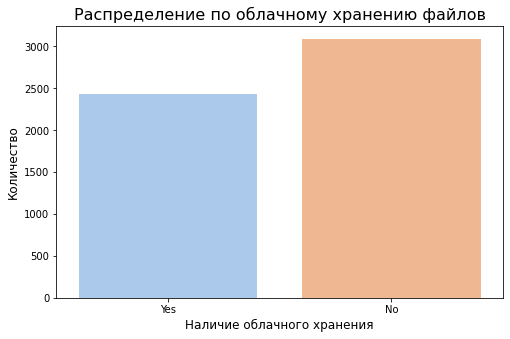

In [42]:
plt.figure(figsize=(8, 5))
sns.countplot(data=internet, x='online_backup', palette='pastel')
plt.title('Распределение по облачному хранению файлов', fontsize=16)
plt.xlabel('Наличие облачного хранения', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Меньшая часть клиентов использует облачное хранилище для резервного копирования данных. Это может означать, что многие пользователи не видят необходимости в резервном копировании данных или предпочитают другие способы защиты информации, например, использование внешних жестких дисков или облачных сервисов.

In [43]:
print(internet['device_protection'].unique())
print(internet['device_protection'].value_counts())

['No' 'Yes']
No     3095
Yes    2422
Name: device_protection, dtype: int64


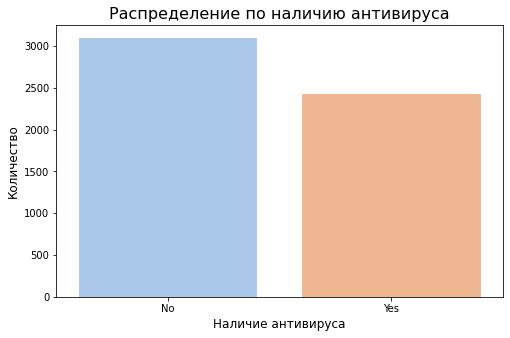

In [44]:
plt.figure(figsize=(8, 5))
sns.countplot(data=internet, x='device_protection', palette='pastel')
plt.title('Распределение по наличию антивируса', fontsize=16)
plt.xlabel('Наличие антивируса', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Несмотря на то, что антивирусная защита является важной частью обеспечения безопасности в интернете, большая часть клиентов не воспользовались этой услугой. 

In [45]:
print(internet['tech_support'].unique())
print(internet['tech_support'].value_counts())

['No' 'Yes']
No     3473
Yes    2044
Name: tech_support, dtype: int64


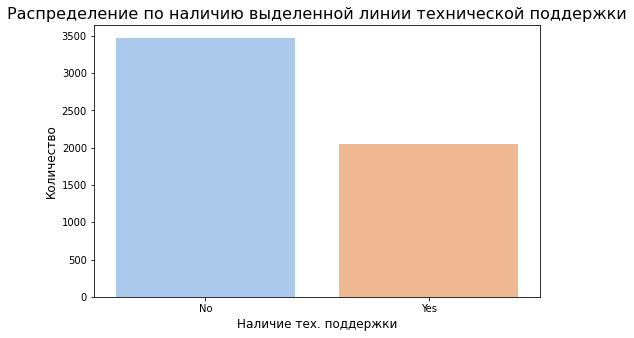

In [46]:
plt.figure(figsize=(8, 5))
sns.countplot(data=internet, x='tech_support', palette='pastel')
plt.title('Распределение по наличию выделенной линии технической поддержки', fontsize=16)
plt.xlabel('Наличие тех. поддержки', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Большинство клиентов не используют выделенную линию технической поддержки, что может свидетельствовать о том, что либо клиенты не считают эту услугу необходимой, либо могут использовать другие каналы для решения своих технических вопросов.

In [47]:
print(internet['streaming_tv'].unique())
print(internet['streaming_tv'].value_counts())

['No' 'Yes']
No     2810
Yes    2707
Name: streaming_tv, dtype: int64


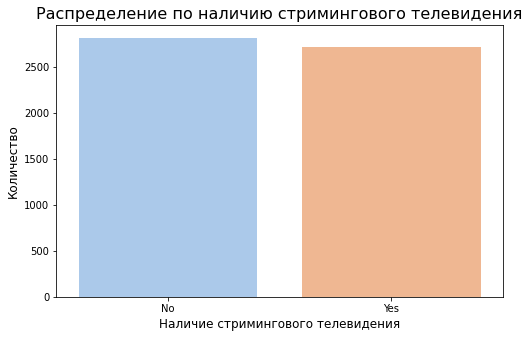

In [48]:
plt.figure(figsize=(8, 5))
sns.countplot(data=internet, x='streaming_tv', palette='pastel')
plt.title('Распределение по наличию стримингового телевидения', fontsize=16)
plt.xlabel('Наличие стримингового телевидения', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Число пользователей стримингового телевидения и не пользователей близки, но чуть больше абонентов (2810) не подключены к этой услуге.

In [49]:
print(internet['streaming_movies'].unique())
print(internet['streaming_movies'].value_counts())

['No' 'Yes']
No     2785
Yes    2732
Name: streaming_movies, dtype: int64


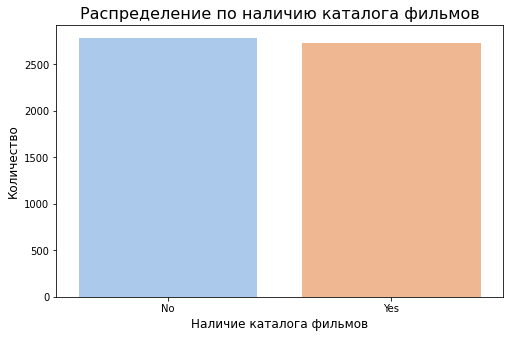

In [50]:
plt.figure(figsize=(8, 5))
sns.countplot(data=internet, x='streaming_movies', palette='pastel')
plt.title('Распределение по наличию каталога фильмов', fontsize=16)
plt.xlabel('Наличие каталога фильмов', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Число клиентов, использующих каталог фильмов, почти равно числу тех, кто не использует эту услугу. Разница между ними незначительная, что указывает на сбалансированное распределение среди пользователей, выбирающих эту опцию.

In [51]:
print(phone['multiple_lines'].unique())
print(phone['multiple_lines'].value_counts())

['No' 'Yes']
No     3390
Yes    2971
Name: multiple_lines, dtype: int64


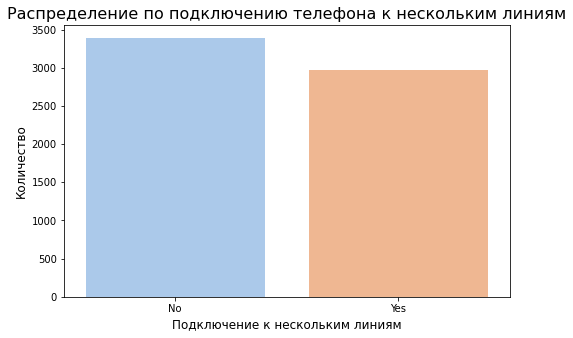

In [52]:
plt.figure(figsize=(8, 5))
sns.countplot(data=phone, x='multiple_lines', palette='pastel')
plt.title('Распределение по подключению телефона к нескольким линиям', fontsize=16)
plt.xlabel('Подключение к нескольким линиям', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.show()

Как видно из графика число клиентов, которые не подключают свои телефоны к возможности ведения параллельных линий во время звонка, несколько выше, чем те, которые подключают данную услугу.

Проведем анализ количественных признаков для датасета contract и построим соответсвующие графики

In [53]:
display(contract[['monthly_charges', 'total_charges']].describe().T)

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2115.312885,2112.742814,0.00,436.75,1343.35,3236.69,9221.38


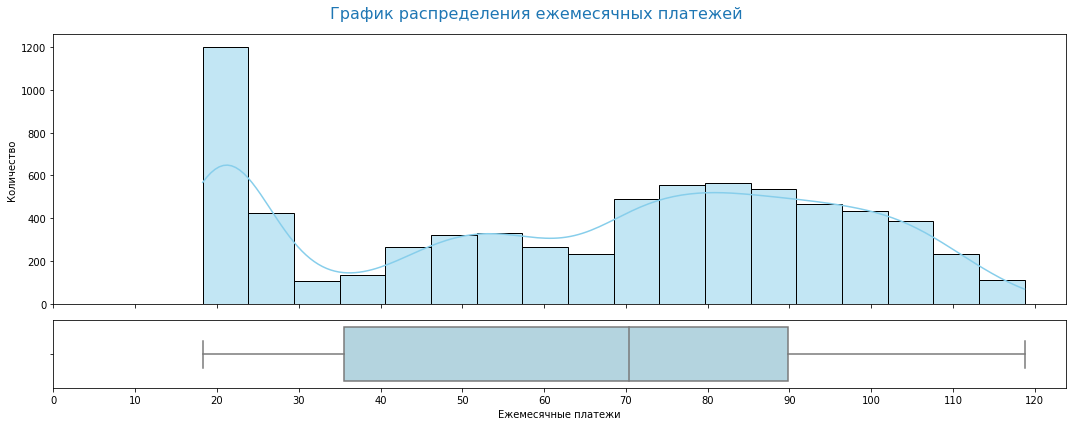

In [54]:
fig, (ax_main, ax_box) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}
)
fig.set_size_inches((15, 6))
sns.histplot(x=contract["monthly_charges"], kde=True, ax=ax_main, color="skyblue").set(ylabel="Количество")
sns.boxplot(x=contract["monthly_charges"], ax=ax_box, color="lightblue")
plt.suptitle("График распределения ежемесячных платежей", size=16, color="C0")
plt.xlabel("Ежемесячные платежи")
ax_main.set_xticks(range(0, 130, 10))
ax_box.set_xticks(range(0, 130, 10))
plt.tight_layout()
plt.show()

По графику распределения видно, что большая часть клиентов платит за услуги примерно от 35.50 до 89.85.

Большой скачок в начале графика (примерно от 18 до 24) говорит о наличии значительного числа клиентов с низкими ежемесячными платежами.  Скорее всего этот ценовой диапазон может соответствовать минимальной стоимости базовых тарифов или услуг, которые выбирают пользователи с ограниченным бюджетом или минимальными потребностями. Эти клиенты, выбирают дешевые базовые тарифы с ограниченными услугами, и поэтому платят меньшие суммы ежемесячных платежей. 
   
В то время другой пик на диаграме скорее всего указывает на клиентов, которые выбирают более дорогие тарифы, возможно, с более широким набором услуг или с дополнительными функциями, и за счет этого платят больше.

Эта информация может быть полезна для разработки стратегии удержания клиентов или продаж дополнительных услуг пользователям, с дешевыми пакетами услуг.

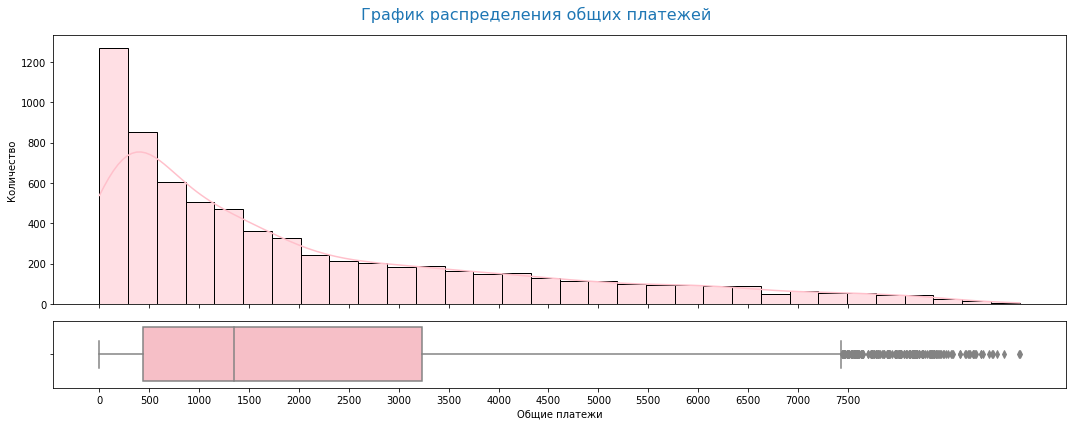

In [55]:
fig, (ax_main, ax_box) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}
)
fig.set_size_inches((15, 6))
sns.histplot(x=contract["total_charges"], kde=True, ax=ax_main, color="pink").set(ylabel="Количество")
sns.boxplot(x=contract["total_charges"], ax=ax_box, color="lightpink")
plt.suptitle("График распределения общих платежей", size=16, color="C0")
plt.xlabel("Общие платежи")
ax_main.set_xticks(range(0, 8000, 500))
ax_box.set_xticks(range(0, 8000, 500))
plt.tight_layout()
plt.show()


У большинства клиентов расходы составили примерно от 450 до 3200.
Также, по графику видно, что большое количество абонентов пользуются более дешевыми услугами. Наибольшее количество наблюдений сосредоточено в низком диапазоне общих платежей. Это может быть связано с выбором более доступных тарифов или с тем, что эти клиенты являются новыми пользователями, которые пока не накопили значительные суммы. По мере увеличения общие расходы абонента, количество клиентов снижается. Это означает, что дорогие услуги или долгосрочные контракты характерны только для небольшой части клиентов.

**Итак, в данном шаге** мы провели первичный анализ и предобработку четырёх исходных датасетов.

Для начала привели все названия столбцов к единому виду, добавив нижнее подчеркивание между строчной и заглавной буквой, а также преобразовали все буквы в нижний регистр. Затем мы вывели количество пропусков в каждом датасете, и как оказалось, в исходных данных отсутствуют пропуски.

Далее проверили корректность типов данных в столбцах. В признаке total_charges, который имел тип object, мы заменили пропуски на числовое значение 0, так как отсутствие данных могло означать, что оплата еще не была произведена. Также преобразовали признак senior_citizen из числового типа в object. Преобразовали столбцы begin_date и end_date в формат даты, заменив значения "No" в end_date на дату выгрузки данных.

Потом нами была определена целевая переменная. Чтобы определить целевой признак, мы использовали столбец end_date. Она была определена как 1 для договоров, действие которых завершилось, и 0 для активных договоров. После этого перепроверили все изменённые типы данных, убедившись в их корректности, и также проверили датасеты на наличие полных дубликатов и обнаружили, что их нет.

Затем мы провели анализ значений всех **категориальных признаков** и выявили несколько интересных паттернов: 

- Клиенты чаще выбирают гибкие условия (Month-to-month), что свидетельствует о предпочтении услуг без долгосрочных обязательств. Долгосрочные контракты (Two year и One year) менее популярны, что может говорить о необходимости предложений, стимулирующих их выбор, например, через скидки или бонусы.
- Большинство клиентов предпочитают электронные расчетные листы, что подчеркивает удобство и доступность цифровых методов. Также видно, что большинство предпочитает электронные чеки для оплаты, но почтовые чеки, автоматические переводы и оплата кредитными картами также остаются популярными.
- В распределении по полу наблюдается небольшое преобладание мужчин среди клиентов. Что касается возрастных категорий, пенсионеры составляют примерно 16% от общего числа абонентов, что также стоит учитывать при разработке продуктов и стратегий.
- Большинство абонентов не имеют партнера, хотя разница с теми, кто имеет партнера, не так велика. Этот момент важен для таргетинга на семьи, например, для предложений совместных тарифов. Также большинство клиентов не имеют детей, однако значительная часть клиентов все же имеет детей.
- Большинство пользователей подключены к оптоволоконному интернету, что может свидетельствовать о предпочтении качественного подключения. Вместе с тем, большинство клиентов не активируют дополнительные услуги, такие как блокировка опасных сайтов и антивирусная защита.
- Меньшее количество клиентов использует облачное хранилище для резервного копирования данных, что может говорить о предпочтении других способов защиты информации. Также видно, что большая часть клиентов не пользуется выделенной линией технической поддержки, что может означать использование других каналов для решения своих технических проблем.
- В распределении пользователей стримингового телевидения и каталога фильмов почти равенство между теми, кто пользуется услугами, и теми, кто не использует эти сервисы. Число пользователей, не подключающих параллельные линии во время звонков, немного выше, чем тех, кто подключает эту услугу.

Обобщенно можно сказать, что большинство клиентов выбирают гибкие условия, предпочитают электронные расчетные листы, не активируют дополнительные услуги, такие как антивирус или блокировка опасных сайтов, и т. д.

Проанализировав **количественные признаки**, мы пришли к следующему выводу: большинство клиентов предпочитают более доступные тарифы, в то время как более дорогие услуги пользуются спросом только у небольшой части пользователей. Это видно из распределений по признакам monthly_charges и total_charges, где большая часть абонентов находится в нижних ценовых диапазонах.

Конкретно, по графику распределения ежемесячных платежей (monthly_charges) видно, что большая доля клиентов выбирают тарифы с низкими ежемесячными затратами. Это может быть связано с тем, что они ищут более экономичные решения, возможно, из-за ограниченности бюджета или предпочтений в выборе базовых услуг, которые не требуют больших расходов. Другой пик — это клиенты с более дорогими тарифами и расширенными услугами. 

Схожие выводы можно сделать по признаку (total_charges), который показывает общие затраты клиента за весь период пользования услугами. Здесь также наблюдается, что большинство абонентов тратят меньше на услуги, что может говорить о том, что они остаются на начальных тарифах или не пользуются дополнительными платными сервисами. С увеличением расходов клиентов их количество снижается, что указывает на малую востребованность дорогих услуг и долгосрочных контрактов.

## Шаг 3. Объединение данных

Далее объединим наши исходные 4 датасета в один при помощи ключа customer_id

In [56]:
# Объединеним датафреймы
data = contract.merge(personal, on='customer_id')
data = data.merge(internet, how='left', on='customer_id')
data = data.merge(phone, how='left', on='customer_id')

In [57]:
# Перепроверим, все ли правильно объединилось
print('Размерность датафрейма "contract":', contract.shape)
print('Размерность датафрейма "personal":', personal.shape)
print('Размерность датафрейма "internet":', internet.shape)
print('Размерность датафрейма "phone":', phone.shape)
print()
print('Размерность датафрейма "data":', data.shape)

Размерность датафрейма "contract": (7043, 9)
Размерность датафрейма "personal": (7043, 5)
Размерность датафрейма "internet": (5517, 8)
Размерность датафрейма "phone": (6361, 2)

Размерность датафрейма "data": (7043, 21)


In [58]:
display(data.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


Перепроверим итоговый датасет на наличие пропусков

In [59]:
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
target                  0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Как мы можем заметить, после объединения датасетов, у нас появились пропуски в столбцах internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies и multiple_lines. Это связано с тем, что при объединении таблиц у клиентов, у которых куплен только один пакет услуг (или интернет или телефония) на месте признаков у альтернативного пакета образуются пропуски. Вместо пропусков введем новую категорию 'no_package' (нет пакета)

In [60]:
data = data.fillna('no_package')

In [61]:
data.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
target               0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Создадим новый признак contract_duration - длительность действия контракта абонента (в днях).

In [62]:
data['contract_duration'] = (data['end_date'] - data['begin_date']).dt.days

Также, столбец senior_citizen, хотя и представлен как числовой тип данных int64, на самом деле является категориальным признаком, а не числовым. Вот почему его нужно преобразовать в тип object

In [63]:
data['senior_citizen'] = data['senior_citizen'].astype('object')

In [64]:
display(data.head())
display(data.info())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,No,DSL,No,Yes,No,No,No,No,no_package,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,no_package,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,Fiber optic,No,No,No,No,No,No,No,153


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   target             7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   object        
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

None

In [65]:
print(data["contract_duration"].isnull().sum())

0


**Итак, на этом этапе** мы объединили четыре исходных датафрейма (contract, personal, internet и phone) в один общий датафрейм data с использованием ключа customer_id. После объединения мы проверили итоговый датасет на наличие пропусков. Пропуски обнаружены в столбцах, связанных с интернет-услугами (internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies) и телефонией (multiple_lines). Это связано с тем, что клиенты, имеющие только один тип услуг (например, интернет или телефонию), не имеют данных по другому типу услуг, что и привело к появлению пропусков. Чтобы корректно обработать эти значения, мы заменили пропуски на новую категорию. Итак, датасет готов, но давайте опять проанализируем признаки.

## Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Рассмотрим распределение классов целевого признака (target). Для этого построим столбчатую диаграмму, чтобы наглядно увидеть, насколько сбалансированы классы.

Это поможет понять, преобладает ли какой-либо из классов и требует ли распределение данных дополнительных действий, таких как балансировка классов. Если один из классов заметно превышает другой, это может повлиять на обучение модели, так как алгоритм будет склонен предсказывать более частый класс.

0    5942
1    1101
Name: target, dtype: int64


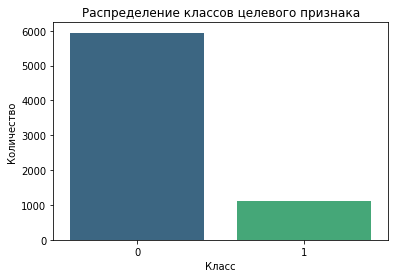

In [66]:
print(data['target'].value_counts())

sns.countplot(data=data, x='target', palette='viridis')
plt.title('Распределение классов целевого признака')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

Как видно, класс 0 значительно преобладает, что указывает на сильный дисбаланс в данных. Это значит, что значительно преобладает класс активных клиентов, у который действие договоров не завершилось и  они пользуюся услугами компании. Далее в работе я буду использовать метрику ROC-AUC, которая хорошо подходит для оценки качества моделей при дисбалансе классов.

Посмотрим на распределение всех категорильных признаков относительно целевого признака (target), где 0 - оставшиеся клиенты, 1 - клиенты, которые прекратили пользоваться услугами компании

In [67]:
def features_by_target(data, column, target):
    print(data[column].value_counts())
    
    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=column, hue=target, palette='pastel')
    plt.title(f'Распределение признака {column} относительно {target}', fontsize=16)
    plt.xlabel(f'{column}', fontsize=12)
    plt.ylabel('Количество', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title=target, loc='upper right')
    plt.show()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64


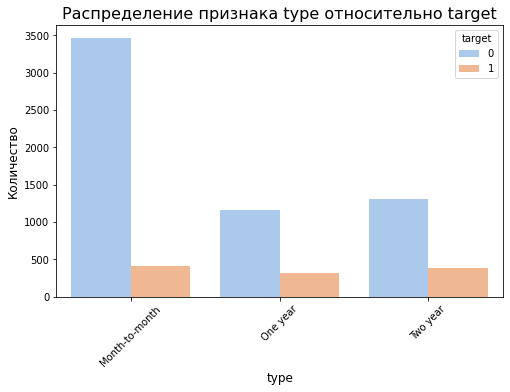

In [68]:
# Применение функции к столбцу 'type' относительно целевого признака 'target'
features_by_target(data, 'type', 'target')

По графику распределения признака type относительно целевого признака target можно сделать вывод, что среди ушедших клиентов типы оплаты (раз в месяц, раз в год, раз в 2 года) примерно одинаковы. Особо значительных различий между ушедшими нет

Yes    4171
No     2872
Name: paperless_billing, dtype: int64


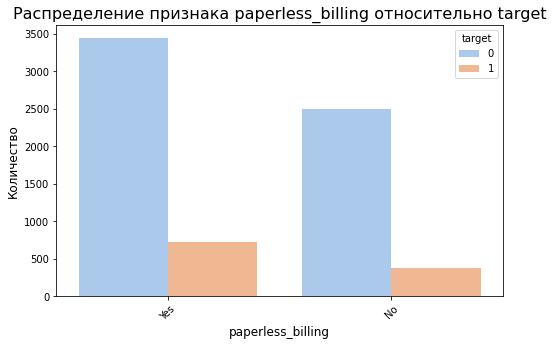

In [69]:
# Применение функции к столбцу 'paperless_billing' относительно целевого признака 'target'
features_by_target(data, 'paperless_billing', 'target')

По графику распределения признака paperless_billing относительно целевого признака target видно, что как среди ушедших, так и среди оставшихся клиентов большинство предпочитают использовать электронный расчётный лист.

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64


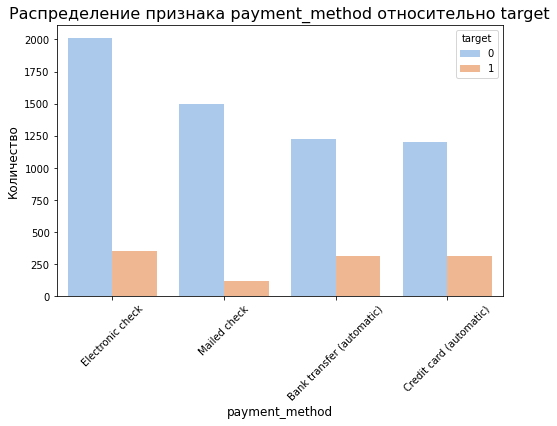

In [70]:
# Применение функции к столбцу 'payment_method' относительно целевого признака 'target'
features_by_target(data, 'payment_method', 'target')

По графику распределения признака payment_method относительно целевого признака target видно, что среди ушедших клиентов те, кто использует Mailed check (почтовые чеки), уходят реже, чем клиенты, предпочитающие другие способы оплаты. Это может свидетельствовать о том, что клиенты, выбирающие почтовые чеки, могут быть более лояльными или оставаться с компанией на более долгий срок по сравнению с теми, кто использует другие методы платежа.

Male      3555
Female    3488
Name: gender, dtype: int64


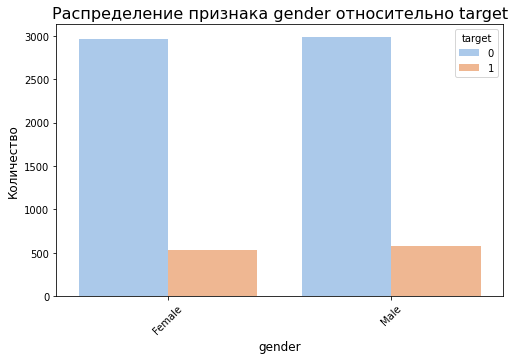

In [71]:
# Применение функции к столбцу 'gender' относительно целевого признака 'target'
features_by_target(data, 'gender', 'target')

Из анализа распределения признака gender относительно целевого признака target видно, что распределение по полу среди ушедших и оставшихся клиентов почти идентично.

0    5901
1    1142
Name: senior_citizen, dtype: int64


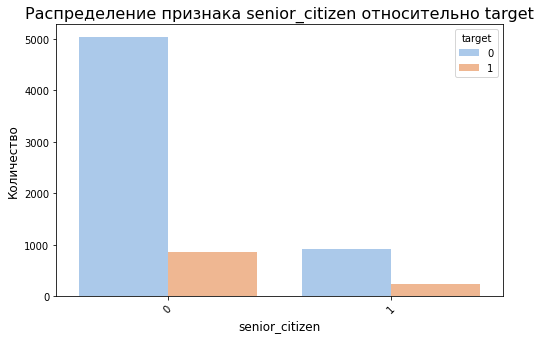

In [72]:
# Применение функции к столбцу 'senior_citizen' относительно целевого признака 'target'
features_by_target(data, 'senior_citizen', 'target')

По графику распределения признака senior_citizen относительно целевого признака target видно, что как среди оставшихся, так и среди ушедших клиентов преобладает категория "не пенсионеры" 

No     3641
Yes    3402
Name: partner, dtype: int64


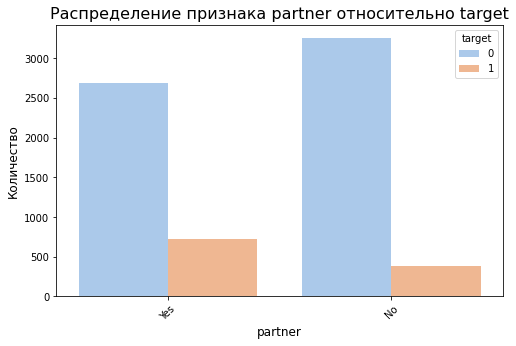

In [73]:
# Применение функции к столбцу 'partner' относительно целевого признака 'target'
features_by_target(data, 'partner', 'target')

По графику распределения признака partner относительно целевого признака target видно, что среди оставшихся клиентов большинство не имеют партнера. В то время как среди ушедших клиентов наблюдается преобладание категории с супругом или супрегой, что означает, что среди тех, кто ушел, больше людей с партнерами. Это может свидетельствовать о повышенном риске ухода для клиентов с партнерами. Возможно, следует рассмотреть возможность предложения совместных тарифов или дополнительных услуг, ориентированных на семейные пары, чтобы снизить этот риск.

No     4933
Yes    2110
Name: dependents, dtype: int64


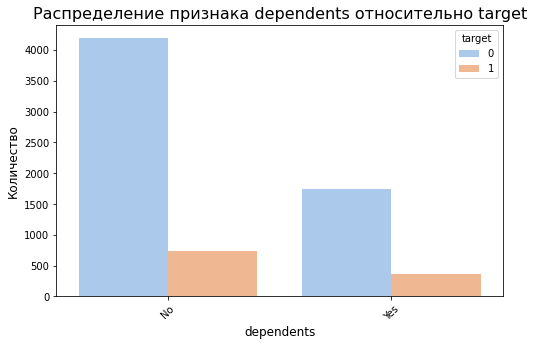

In [74]:
# Применение функции к столбцу 'dependents' относительно целевого признака 'target'
features_by_target(data, 'dependents', 'target')

По графику распределения признака dependents относительно целевого признака target видно, что в обеих группах — как среди оставшихся клиентов, так и среди ушедших — преобладают те, у кого нет детей.

Fiber optic    3096
DSL            2421
no_package     1526
Name: internet_service, dtype: int64


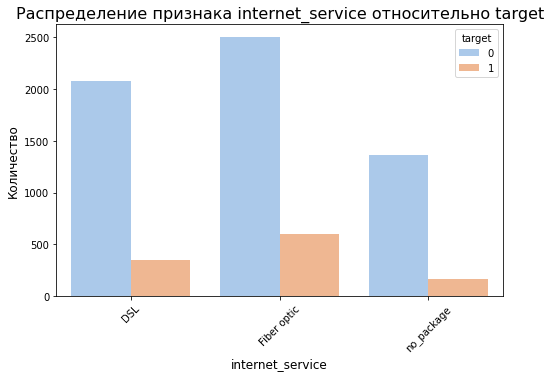

In [75]:
# Применение функции к столбцу 'internet_service' относительно целевого признака 'target'
features_by_target(data, 'internet_service', 'target')

По графику распределения признака internet_service относительно целевого признака target видно, что среди оставшихся и ушедших клиентов ситуация распределяется схоже. В обеих группах преобладает категория клиентов, использующих оптоволоконное подключение (Fiber optic), за ними идет категория клиентов с DSL-соединением.

No            3498
Yes           2019
no_package    1526
Name: online_security, dtype: int64


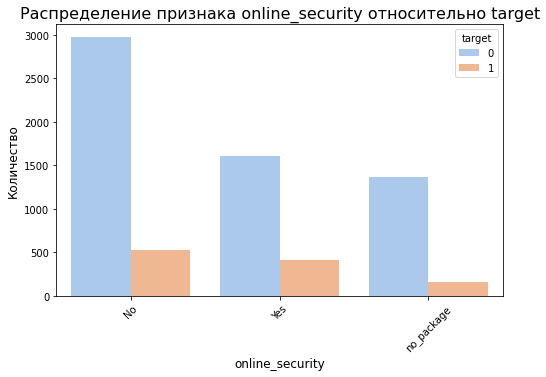

In [76]:
# Применение функции к столбцу 'online_security' относительно целевого признака 'target'
features_by_target(data, 'online_security', 'target')

По графику распределения признака online_security относительно целевого признака target видно, что среди оставшихся клиентов значительно больше тех, кто не использует услугу блокировки опасных сайтов. Среди ушедших клиентов распределение более равномерное, но все же немного больше тех, кто не использует эту услугу.

No            3088
Yes           2429
no_package    1526
Name: online_backup, dtype: int64


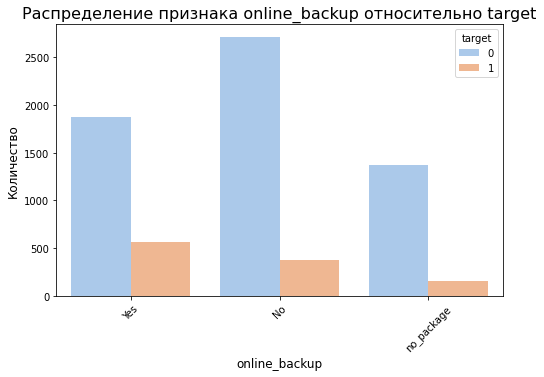

In [77]:
# Применение функции к столбцу 'online_backup' относительно целевого признака 'target'
features_by_target(data, 'online_backup', 'target')

По графику распределения признака online_backup относительно целевого признака target видно, что среди оставшихся клиентов большинство не используют облачное хранилище для резервного копирования данных. В то время как среди ушедших клиентов большая часть использовали эту услугу. В целом можно сказать, что использование облачного хранилища может быть недостаточным фактором для удержания клиентов, если другие важные аспекты обслуживания не соответствуют ожиданиям или потребностям клиентов.

No            3095
Yes           2422
no_package    1526
Name: device_protection, dtype: int64


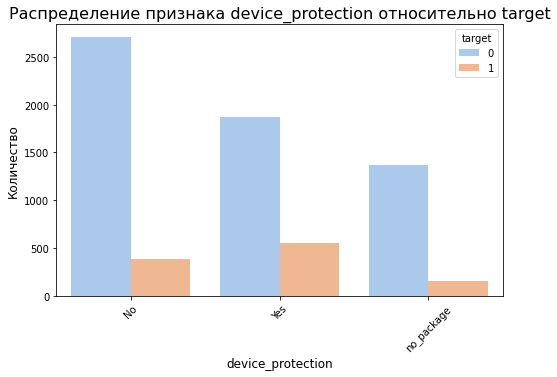

In [78]:
# Применение функции к столбцу 'device_protection' относительно целевого признака 'target'
features_by_target(data, 'device_protection', 'target')

На графике распределения признака device_protection относительно целевого признака target видно, что среди оставшихся клиентов большинство не используют антивирусную защиту. В то время как среди ушедших клиентов больше тех, кто подключал эту услугу. Это может указывать на то, что антивирусная защита не играет решающей роли в удержании клиентов. Для некоторых пользователей эта услуга может восприниматься как базовая или неважная, и их решение покинуть компанию скорее связано с другими факторами, такими как недостаток других сервисов или возможно низкое качество обслуживания.

No            3473
Yes           2044
no_package    1526
Name: tech_support, dtype: int64


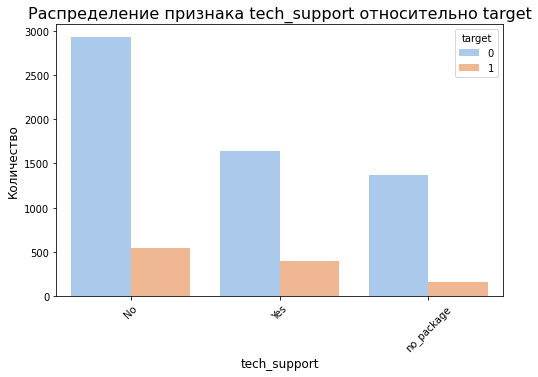

In [79]:
# Применение функции к столбцу 'tech_support' относительно целевого признака 'target'
features_by_target(data, 'tech_support', 'target')

По графику распределения признака tech_support относительно целевого признака target видно, что как среди оставшихся клиентов, так и среди ушедших, большинство не используют техническую поддержку. 

No            2810
Yes           2707
no_package    1526
Name: streaming_tv, dtype: int64


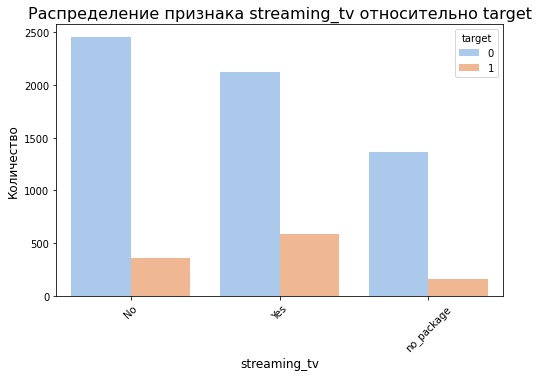

In [80]:
# Применение функции к столбцу 'streaming_tv' относительно целевого признака 'target'
features_by_target(data, 'streaming_tv', 'target')

Распределение признака streaming_tv относительно целевого признака target показывает, что среди оставшихся клиентов большинство не пользуются услугой стримингового телевидения. В то время как среди ушедших клиентов, наоборот, больше тех, кто использовали эту услугу.

No            2785
Yes           2732
no_package    1526
Name: streaming_movies, dtype: int64


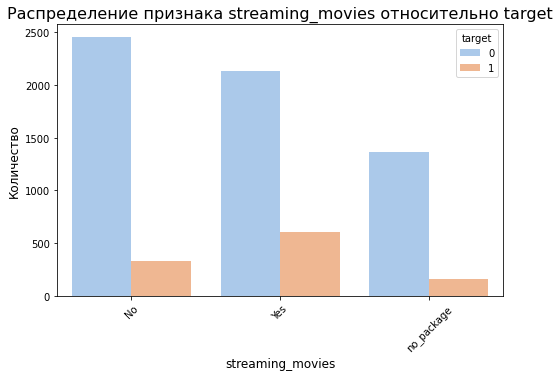

In [81]:
# Применение функции к столбцу 'streaming_movies' относительно целевого признака 'target'
features_by_target(data, 'streaming_movies', 'target')

По аналогии со стриминговым телевидением, среди ушедших клиентов больше тех, кто использует услугу каталога фильмов. Однако уход этих клиентов может быть связан не только с использованием услуги, но и с другими факторами, например такими как неудовлетворенность качеством других услуг, высокая стоимость тарифа, конкуренция с более привлекательными предложениями других компаний или личные предпочтения и потребности клиентов.

No            3390
Yes           2971
no_package     682
Name: multiple_lines, dtype: int64


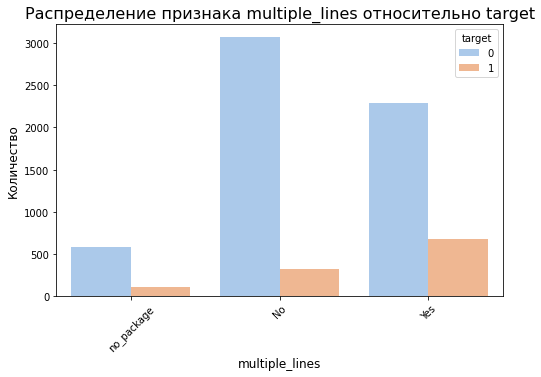

In [82]:
# Применение функции к столбцу 'multiple_lines' относительно целевого признака 'target'
features_by_target(data, 'multiple_lines', 'target')

По графику распределения признака multiple_lines относительно целевого признака target видно, что среди оставшихся клиентов преобладает категория тех, кто не использует подключение к нескольким линиям одновременно. В то время как среди ушедших клиентов больше тех, кто использует эту услугу.

Это может свидетельствовать о том, что для клиентов, использующих подключение к нескольким линиям, уход из компании может быть связан с тем, что данная услуга не оправдала ожиданий или не была достаточно важной для продолжения контракта. Возможно, другие факторы, такие как общая стоимость пакета услуг или потребности в других услугах, повлияли на решение уйти.

Теперь посмотрим на наши колличественные признаки monthly_charges, total_charges и contract_duration в таблице data относительно целевого признака target

In [83]:
print('Класс 0:')
display(data[data['target'] == 0][['monthly_charges', 'total_charges', 'contract_duration']].describe().T)
print('Класс 1:')
display(data[data['target'] == 1][['monthly_charges', 'total_charges', 'contract_duration']].describe().T)

Класс 0:


,count,mean,std,min,25%,50%,75%,max
monthly_charges,5942.0,62.763455,29.844462,18.25,30.0625,69.2,87.2375,118.60
total_charges,5942.0,2067.866420,2193.898483,0.00,374.3525,1192.8,3173.8375,9221.38
contract_duration,5942.0,893.681084,716.958551,0.00,245.0000,702.0,1523.0000,2314.00


Класс 1:


,count,mean,std,min,25%,50%,75%,max
monthly_charges,1101.0,75.546004,29.116213,18.40,56.15,84.20,99.50,118.75
total_charges,1101.0,2371.377275,1581.862275,77.84,1048.05,2139.03,3404.91,7649.76
contract_duration,1101.0,924.863760,458.771309,28.00,577.00,915.00,1249.00,2129.00


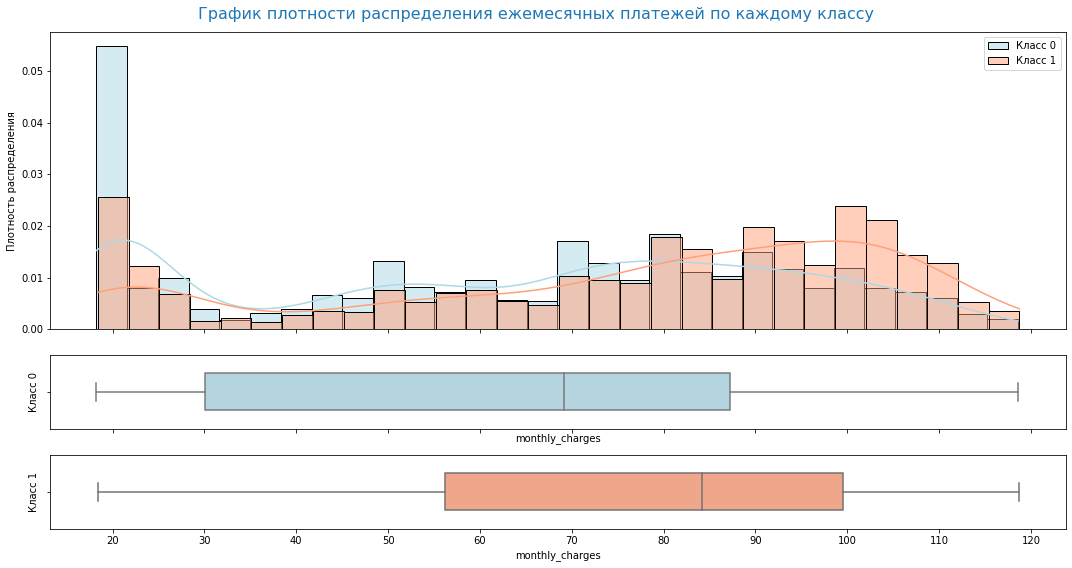

In [84]:
# Создаем подграфики для monthly_charges
fig, (ax_main, ax_box_0, ax_box_1) = plt.subplots(
    3, sharex=True, gridspec_kw={"height_ratios": (.8, .2, .2)}
)
fig.set_size_inches((15, 8))

# Нормированная гистограмма для target == 0 и target == 1
sns.histplot(
    x=data[data["target"] == 0]["monthly_charges"], 
    kde=True, 
    ax=ax_main, 
    color="lightblue", 
    label="Класс 0", 
    bins=30, 
    stat='density', 
    common_norm=False
)
sns.histplot(
    x=data[data["target"] == 1]["monthly_charges"], 
    kde=True, 
    ax=ax_main, 
    color="lightsalmon", 
    label="Класс 1", 
    bins=30, 
    stat='density', 
    common_norm=False
)
ax_main.set_ylabel("Плотность распределения")
ax_main.set_xlabel("Ежемесячные платежи")
ax_main.set_xticks(range(0, 130, 10))
ax_main.legend()

# Boxplot для target = 0
sns.boxplot(
    x=data[data["target"] == 0]["monthly_charges"], 
    ax=ax_box_0, 
    color="lightblue", 
    width=0.5
)
ax_box_0.set_ylabel("Класс 0")

# Boxplot для target = 1
sns.boxplot(
    x=data[data["target"] == 1]["monthly_charges"], 
    ax=ax_box_1, 
    color="lightsalmon", 
    width=0.5
)
ax_box_1.set_ylabel("Класс 1")

plt.suptitle("График плотности распределения ежемесячных платежей по каждому классу", size=16, color="C0")
plt.tight_layout()
plt.show()

На графике наблюдается, что плотность ушедших клиентов (Класс 1) значительно выше среди клиентов с более высокими ежемесячными платежами. Особенно это заметно в диапазоне от 80 до 120, где концентрация клиентов, покинувших сервис, наиболее выражена. Возможно, эти клиенты не находят нужной ценности в предоставляемых услугах при данной стоимости, или же существует другие факторы, влияющие на их решение о прекращении контракта.

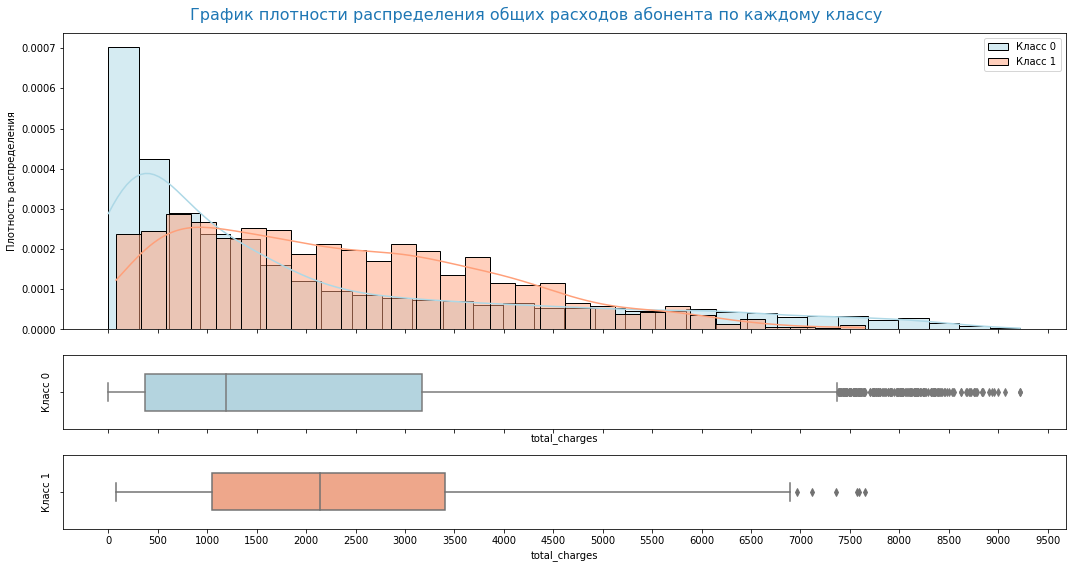

In [85]:
# Создаем подграфики для total_charges
fig, (ax_main, ax_box_0, ax_box_1) = plt.subplots(
    3, sharex=True, gridspec_kw={"height_ratios": (.8, .2, .2)}
)
fig.set_size_inches((15, 8))

# Нормированная гистограмма для target == 0 и target == 1
sns.histplot(
    x=data[data["target"] == 0]["total_charges"], 
    kde=True, 
    ax=ax_main, 
    color="lightblue", 
    label="Класс 0", 
    bins=30, 
    stat='density', 
    common_norm=False
)
sns.histplot(
    x=data[data["target"] == 1]["total_charges"], 
    kde=True, 
    ax=ax_main, 
    color="lightsalmon", 
    label="Класс 1", 
    bins=30, 
    stat='density', 
    common_norm=False
)
ax_main.set_ylabel("Плотность распределения")
ax_main.set_xlabel("Общие платежи")
ax_main.set_xticks(range(0, 10000, 500))
ax_main.legend()

# Boxplot для target = 0
sns.boxplot(
    x=data[data["target"] == 0]["total_charges"], 
    ax=ax_box_0, 
    color="lightblue", 
    width=0.5
)
ax_box_0.set_ylabel("Класс 0")

# Boxplot для target = 1
sns.boxplot(
    x=data[data["target"] == 1]["total_charges"], 
    ax=ax_box_1, 
    color="lightsalmon", 
    width=0.5
)
ax_box_1.set_ylabel("Класс 1")

plt.suptitle("График плотности распределения общих расходов абонента по каждому классу", size=16, color="C0")
plt.tight_layout()
plt.show()

Среди ушедших клиентов не наблюдается большого скачка в самом начале, как это видно на графике для активных пользователей. Общий объем расходов у половины пользователей класса 0 не превышает 1200, а у класса 1 эта сумма составляет уже 2200. Это говорит о том, что клиенты, покинувшие сервис, тратили на сервис больше, чем те, кто остался. Возможно, эти клиенты не получили достаточную удовлетворенность услугами компании или ожидали большего, что в итоге привело к их уходу.

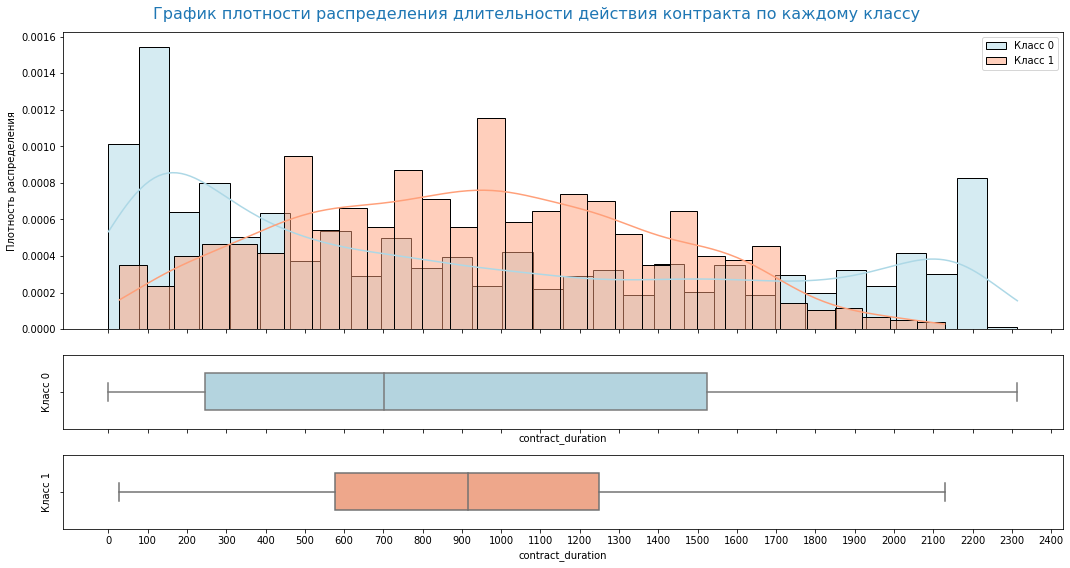

In [86]:
# Создаем подграфики для contract_duration
fig, (ax_main, ax_box_0, ax_box_1) = plt.subplots(
    3, sharex=True, gridspec_kw={"height_ratios": (.8, .2, .2)}
)
fig.set_size_inches((15, 8))

# Нормированная гистограмма для target == 0 и target == 1
sns.histplot(
    x=data[data["target"] == 0]["contract_duration"], 
    kde=True, 
    ax=ax_main, 
    color="lightblue", 
    label="Класс 0", 
    bins=30, 
    stat='density', 
    common_norm=False
)
sns.histplot(
    x=data[data["target"] == 1]["contract_duration"], 
    kde=True, 
    ax=ax_main, 
    color="lightsalmon", 
    label="Класс 1", 
    bins=30, 
    stat='density', 
    common_norm=False
)
ax_main.set_ylabel("Плотность распределения")
ax_main.set_xlabel("Длительность действия контракта")
ax_main.set_xticks(range(0, 2500, 100))
ax_main.legend()

# Boxplot для target = 0
sns.boxplot(
    x=data[data["target"] == 0]["contract_duration"], 
    ax=ax_box_0, 
    color="lightblue", 
    width=0.5
)
ax_box_0.set_ylabel("Класс 0")

# Boxplot для target = 1
sns.boxplot(
    x=data[data["target"] == 1]["contract_duration"], 
    ax=ax_box_1, 
    color="lightsalmon", 
    width=0.5
)
ax_box_1.set_ylabel("Класс 1")

# Обновляем заголовок
plt.suptitle("График плотности распределения длительности действия контракта по каждому классу", size=16, color="C0")
plt.tight_layout()
plt.show()

Как видно из графика, с увеличением срока действия контракта наблюдается рост числа пользователей, продолжающих использовать услуги компании, и также наблюдается снижение числа тех, кто отказался от них. Таким образом, чем дольше клиент остается с компанией, тем ниже вероятность его ухода.  Это свидетельствует о том, что с течением времени лояльность клиентов укрепляется, и их вероятность уйти становится меньше.

Далее, после анализа признаков, можно провести корреляционный анализ для оценки взаимосвязей между ними. Это позволит выявить, какие признаки оказывают влияние друг на друга и в какой степени

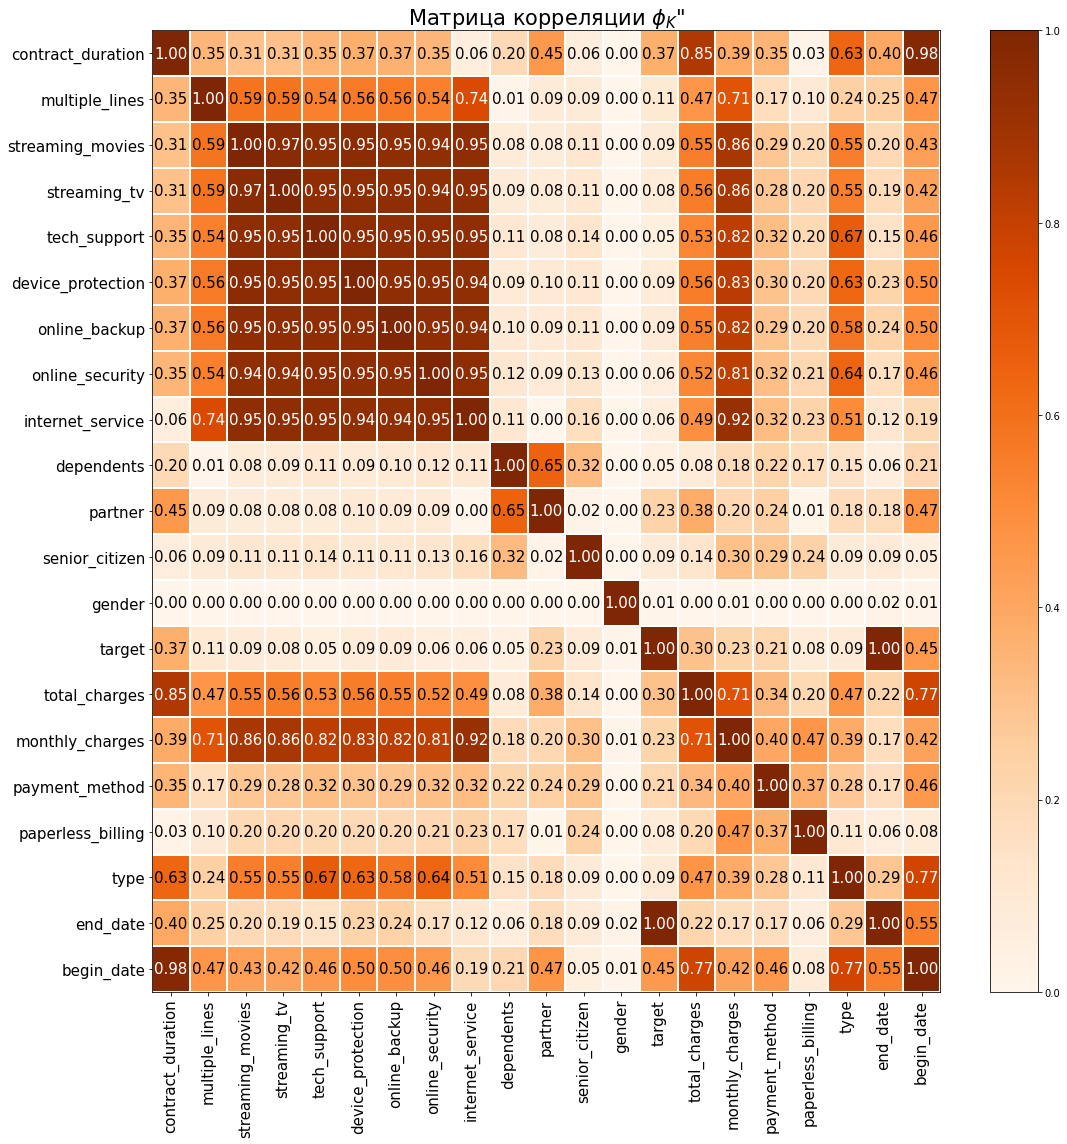

In [87]:
data=data.set_index('customer_id')
# Вычисление корреляционной матрицы коэффициента Фи
interval_cols = ['monthly_charges', 'total_charges', 'contract_duration']
phik_matrix = data.phik_matrix(interval_cols=interval_cols)

# Построение тепловой карты для визуализации корреляционной матрицы
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'Матрица корреляции $\phi_K$"',
    fontsize_factor=1.5,
    figsize=(16, 16)
)
plt.show()

Что мы видим по матрице корреляции:

Самая низкая корреляция со всеми параметрами у признака gender. Этот параметр практически не связан с другими признаками, так как практически все коэффициенты корреляции равны нулю. Это говорит о том, что пол пользователей не влияет на остальные параметры. Можно смело удалять этот признак, так как он, скорее всего, не улучшит качество модели и лишь добавит лишний шум.

Наблюдается сильная взаимосвязь между признаками, описывающими интернет-сервисы, такими как internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv и streaming_movies. Это логично, так как многие из этих услуг приобретаются в комплексе.
  
Наибольшее влияние на целевую переменную оказывают следующие признаки:
- Длительность контракта (contract_duration): коэффициент корреляции составляет 0.37, что указывает на умеренную связь. Чем дольше клиент остается с компанией, тем меньше вероятность его ухода.
- Общие расходы клиента (total_charges): коэффициент корреляции равен 0.3, что также указывает на умеренную связь.
- Тип платежа (payment_method) - 0.21
Это указывает на то, что эти признаки могут быть важными для предсказания.

На значения как месячных (monthly_charges), так и общих (total_charges) расходов абонентов заметное влияние оказывают услуги, связанные с интернетом. Это подтверждает, что интернет-сервисы составляют основную часть затрат клиентов.

Также, можно заметить, что у есть высокая корреляция между total_charges и contract_duration - 0.85, что логичо, т.к. чем дольше клиент платит, тем больше итоговая сумма.

Для признака monthly_charges наблюдается высокая корреляция с рядом других признаков, включая значения, превышающие 0.9. Это говорим нам о таком явлении, как мультиколлинеарность. Для устранения этой проблемы целесообразно удалить признак monthly_charges, так как он дублирует информацию из других переменных.

Высокая корреляция между begin_date и contract_duration (0.98) объяснима, так как продолжительность контракта рассчитывается на основе даты начала. Поэтому, после извлечения полезной информации из дат, сами поля begin_date и end_date можно удалить чтобы избежать мультиколлинеарности и для модели они в их исходном виде не нужны.

In [88]:
data_new = data.drop(['begin_date', 'end_date', 'monthly_charges', 'gender'], axis=1)

Так как у нас наблюдается между различными интернет-услугами высокая коллинеарность, так как пользователи часто подключают сразу несколько услуг. Поэтому заменим эти столбцы одним, отражающим общее количество подключённых услуг, чтобы избежать мультиколлинеальности признаков

In [89]:
# Укажем столбцы, которые представляют интернет услуги.
internet_services = [
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies', 'internet_service'
]

# Создаём новый столбец с подсчётом количества подключённых интернет-услуг
data_new['count_int_services'] = data_new[internet_services].apply(lambda row: (row == 'Yes').sum(), axis=1)

# Удалите исходные столбцы услуг.
data_new.drop(columns=internet_services, inplace=True)

In [90]:
# проверка
data_new.head(5)

,type,paperless_billing,payment_method,total_charges,target,senior_citizen,partner,dependents,multiple_lines,contract_duration,count_int_services
customer_id,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,31.04,0,0,Yes,No,no_package,31,1
5575-GNVDE,One year,No,Mailed check,2071.84,0,0,No,No,No,1036,2
3668-QPYBK,Month-to-month,Yes,Mailed check,226.17,0,0,No,No,No,123,2
7795-CFOCW,One year,No,Bank transfer (automatic),1960.60,0,0,No,No,no_package,1371,3
9237-HQITU,Month-to-month,Yes,Electronic check,353.50,0,0,No,No,No,153,0


In [91]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                7043 non-null   object 
 1   paperless_billing   7043 non-null   object 
 2   payment_method      7043 non-null   object 
 3   total_charges       7043 non-null   float64
 4   target              7043 non-null   int64  
 5   senior_citizen      7043 non-null   object 
 6   partner             7043 non-null   object 
 7   dependents          7043 non-null   object 
 8   multiple_lines      7043 non-null   object 
 9   contract_duration   7043 non-null   int64  
 10  count_int_services  7043 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 660.3+ KB


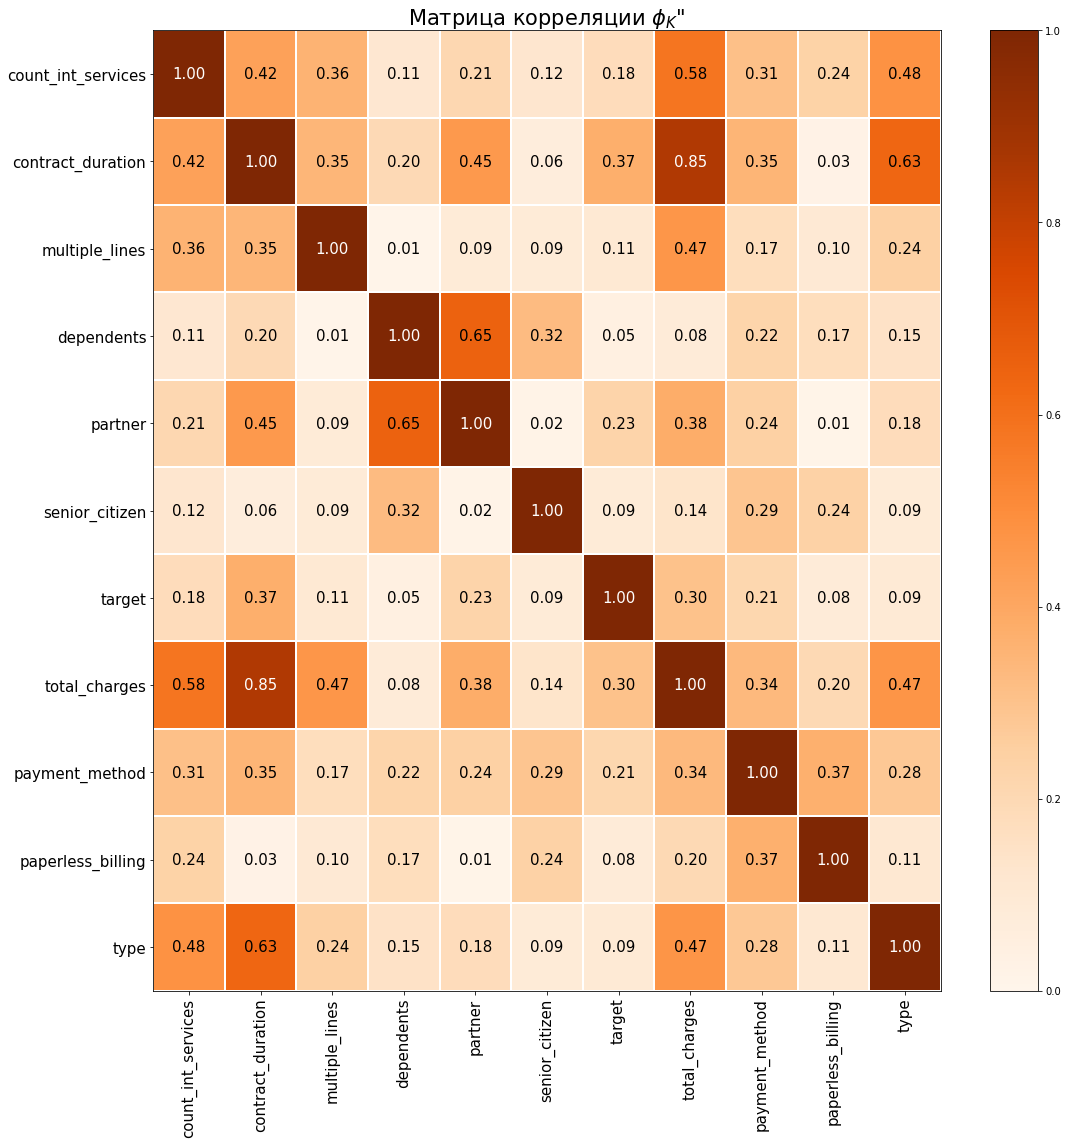

In [92]:
# проверка
# Вычисление корреляционной матрицы коэффициента Фи для новой таблицы
interval_cols = ['total_charges', 'contract_duration']
phik_matrix_2 = data_new.phik_matrix(interval_cols=interval_cols)


plot_correlation_matrix(
    phik_matrix_2.values,
    x_labels=phik_matrix_2.columns,
    y_labels=phik_matrix_2.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'Матрица корреляции $\phi_K$"',
    fontsize_factor=1.5,
    figsize=(16, 16)
)
plt.show()

In [93]:
data_new.columns

Index(['type', 'paperless_billing', 'payment_method', 'total_charges',
       'target', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'contract_duration', 'count_int_services'],
      dtype='object')

После анализа матрицы корреляций я выявила признаки с высокой взаимной корреляцией более 0.9, которые могли вызывать мультиколлинеарность и негативно сказываться на качестве модели. Чтобы этого избежать, я преобразовала данные: исключила сильно коррелирующие признаки, заменив их одним более информативным, либо полностью удалив их.

Теперь признаки подготовлены для дальнейшего анализа, их взаимное влияние минимизировано, и можно переходить к работе с моделями.

**В четвертом шаге своей работы** я провела анализ распределения классов целевого признака (target), чтобы оценить баланс в данных. Я построила столбчатую диаграмму, на которой четко видно, что класс 0 значительно преобладает, что указывает на сильный дисбаланс данных. Это означает, что большинство клиентов продолжают пользоваться услугами компании, в то время как менее значительная часть клиентов прекратила использование услуг. В дальнейшем для оценки качества модели я использую метрику ROC-AUC, так как она хорошо подходит для работы с дисбалансированными классами.

Далее я проанализировала распределение категориальных признаков относительно целевого признака. Например, по признаку type оказалось, что среди ушедших клиентов типы оплаты распределяются равномерно. По признаку payment_method я обнаружила, что клиенты, использующие почтовые чеки, уходят реже, что может свидетельствовать о более высокой лояльности таких пользователей. По признаку partner можно заметить, что среди оставшихся клиентов большинство не состоит в отношениях. Напротив, среди ушедших клиентов более заметно преобладает категория с супругом или супругой. В то время как для других признаков, таких как paperless_billing, gender и dependents, не наблюдается значительных различий между оставшимися и ушедшими клиентами.

Кроме того, я проанализировала различные услуги, связанные с интернетом, такие как подключение, безопасность, резервное копирование, стриминговые сервисы и техническая поддержка. Эти факторы оказались важными для понимания того, как они могут влиять на вероятность ухода клиента. По графикам распределения признаков видно, что среди оставшихся и ушедших клиентов преобладают пользователи с оптоволоконным подключением. Большинство оставшихся клиентов не используют блокировку опасных сайтов и облачное хранилище, в то время как ушедшие пользователи чаще используют эти услуги. Услуга антивирусной защиты не влияет на удержание клиентов, так как большинство клиентов, как оставшихся, так и ушедших, не используют ее. Также среди ушедших клиентов больше пользователей стримингового телевидения и каталога фильмов, однако уход может быть связан с другими факторами, такими как качество обслуживания и стоимость тарифа.

Далее мы провели анализ количественных признаков: ежемесячных расходов, общих затрат и продолжительности контракта и установили, что:
  - Клиенты с высокими платежами чаще уходят.У ушедших клиентов (Класс 1) больше плотность среди тех, кто платит высокие ежемесячные взносы, особенно в диапазоне от 80 до 120. Это может указывать на отсутствие ценности для них при такой стоимости. Клиенты из класса 1 тратят больше, чем те, кто остался, что может быть причиной их ухода.
  - Чем дольше клиент остаётся с компанией, тем меньше вероятность его ухода. С увеличением срока контракта растет количество оставшихся клиентов и снижается число ушедших, что свидетельствует о повышении лояльности с течением времени.
  - Общие затраты клиентов, прекративших пользоваться услугами, выше, чем у оставшихся.

И в конце мы провели корреляционный анализ признаков и выявили:
  - Высокую взаимосвязь между признаками интернет-услуг и признаками, связанными ежемесечными с затратами.
  - Наибольшее влияние на целевую переменную оказывают признаки: длительность контракта, общие расходы клиента и метод оплаты.
  - Мультиколлинеарность между признаками, такими как ежемесячные и общие затраты, а также интернет-услугами. Чтобы ее устранить мы удалили или трансформировали признаки.
  - Также мы удалили признаки даты начала/окончания контракта. Эти признаки были удалены, потому что они предназначены для работы с временными рядами, где важно учитывать хронологическую последовательность событий. Для нашей задачи, в которой мы прогнозируем вероятность ухода клиентов, эти признаки не несут существенной информации, так как уже учтены в признаке contract_duration. Использование дат в модели могло бы привести к мультиколлинеарности и избыточности данных, что не улучшает качество предсказаний.

Теперь, с учетом всех полученных данных, мы можем перейти к подготовке и созданию модели, которая поможет предсказать вероятность расторжения договора и оптимизировать стратегию взаимодействия с клиентами.

## Шаг 5. Подготовка данных

Перед обучением моделей необходимо подготовить данные, для чего мы используем пайплайны. Разделим данные на тренировочную и тестовую выборки в соотношении 75:25. Для преобразования категориальных признаков (type, paperless_billing, payment_method, senior_citizen, partner, dependents, multiple_lines) используем метод One-Hot Encoding (OHE). Количественные признаки total_charges, count_int_services и contract_duration подвергнем масштабированию.
Целевой признак — 'target'.

Создадим пайплайн

Используем стратификацию при разбиении на выборки. Это позволит сохранить первоначальный дисбаланс целевого признака в выборках.

In [94]:
data_new = data_new.reset_index()  
data_new = data_new.drop('customer_id', axis=1) 

X = data_new.drop('target', axis=1)
y = data_new['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

In [95]:
ohe_columns = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'multiple_lines']
num_columns = ['total_charges', 'count_int_services', 'contract_duration']

In [96]:
data_new.head()

,type,paperless_billing,payment_method,total_charges,target,senior_citizen,partner,dependents,multiple_lines,contract_duration,count_int_services
0,Month-to-month,Yes,Electronic check,31.04,0,0,Yes,No,no_package,31,1
1,One year,No,Mailed check,2071.84,0,0,No,No,No,1036,2
2,Month-to-month,Yes,Mailed check,226.17,0,0,No,No,No,123,2
3,One year,No,Bank transfer (automatic),1960.60,0,0,No,No,no_package,1371,3
4,Month-to-month,Yes,Electronic check,353.50,0,0,No,No,No,153,0


In [97]:
#OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

In [98]:
#ORD
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord', 
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
        )
    ]
)

In [99]:
# Преобразователи для числовых данных
num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

In [100]:
data_preprocessor_1 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [101]:
data_preprocessor_2 = ColumnTransformer(
    [
        ('ord', ord_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [102]:
pipe_final_lr = Pipeline(
    [
        ('preprocessor', data_preprocessor_1),
        ('model', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)

In [103]:
pipe_final_rf = Pipeline(
    [
        ('preprocessor', data_preprocessor_2),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)

In [104]:
pipe_final_dt = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

Итак, теперь, когда данные подготовлены, можно перейти к следующему этапу — обучению моделей. На следующем шаге мы будем выбирать подходящие алгоритмы для построения модели. Для этого важно учитывать тип задачи, в нашем же случае это задача классификации.

## Шаг 6. Обучение моделей машинного обучения

**1. Модель LogisticRegression**

In [105]:
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()
X_test_lr = X_test.copy()
y_test_lr = y_test.copy()

In [106]:
# Гиперпараметры для LogisticRegression
param_grid_lr = {
    'model__penalty': ['l2'], 
    'model__C': list(range(1, 15, 3)),
    'model__solver': ['liblinear', 'lbfgs']
}

random_search_lr = RandomizedSearchCV(
    pipe_final_lr, 
    param_distributions=param_grid_lr, 
    cv=5,
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_iter=8,
    n_jobs=-1
)

random_search_lr.fit(X_train_lr, y_train_lr)

lr_params = random_search_lr.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", lr_params)
print("Метрика ROC-AUC, полученная с помощью кросс валидации:", (random_search_lr.best_score_))


Лучшие параметры: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 4}
Метрика ROC-AUC, полученная с помощью кросс валидации: 0.75186831197443


In [107]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
lr_model = random_search_lr.best_estimator_

lr_model.fit(X_train_lr, y_train_lr)

# Время обучения
end = time.time()
time_lr_fit =end-start
print(f"Время обучения модели LogisticRegression на тренировочной выборке: {time_lr_fit:.2f} секунд")

Время обучения модели LogisticRegression на тренировочной выборке: 0.30 секунд
CPU times: user 201 ms, sys: 89.8 ms, total: 291 ms
Wall time: 299 ms


In [108]:
%%time
# Время предсказания модели LogisticRegression
start_time = time.time()
y_pred_lr = lr_model.predict(X_train_lr)
end_time = time.time()
prediction_time_lr = end_time - start_time
print(f"Время предсказания модели LogisticRegression: {prediction_time_lr:.2f} секунд")

Время предсказания модели LogisticRegression: 0.11 секунд
CPU times: user 26.4 ms, sys: 48.3 ms, total: 74.7 ms
Wall time: 111 ms


Мы провели обучение модели LogisticRegression с использованием оптимальных гиперпараметров: solver установлен в 'lbfgs', penalty — 'l2', а C составляет 4. Качество модели на кросс-валидации (метрика roc_auc) составило 0.7519. Найденное время обучения и предсказания, а также это качество модели на кросс-валидации будут в дальнейшем сравниваться с другими моделями, чтобы выбрать наилучшую модель по трем критериям.

**2. RandomForestClassifier**

In [109]:
X_train_rf = X_train.copy()
y_train_rf = y_train.copy()
X_test_rf = X_test.copy()
y_test_rf = y_test.copy()

In [110]:
# Гиперпараметры для RandomForestClassifier
param_grid_rf = {
    'model__max_depth': [10, 15, 20], 
    'model__n_estimators': list(range(50, 350, 50)),
    'model__criterion': ['gini', 'entropy']
                                }


random_search_rf = RandomizedSearchCV(
    pipe_final_rf, 
    param_distributions=param_grid_rf, 
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=5,  
    cv=3, 
    n_jobs=-1  
)

random_search_rf.fit(X_train_rf, y_train_rf)

rf_params = random_search_rf.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", rf_params)
print("Метрика ROC-AUC, полученная с помощью кросс валидации:", random_search_rf.best_score_)


Лучшие параметры: {'model__n_estimators': 150, 'model__max_depth': 10, 'model__criterion': 'entropy'}
Метрика ROC-AUC, полученная с помощью кросс валидации: 0.818354737299052


In [111]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
rf_model = random_search_rf.best_estimator_

rf_model.fit(X_train_rf, y_train_rf)

# Время обучения
end = time.time()
time_rf_fit =end-start
print(f"Время обучения модели RandomForestClassifier на тренировочной выборке: {time_rf_fit:.2f} секунд")

Время обучения модели RandomForestClassifier на тренировочной выборке: 0.71 секунд
CPU times: user 698 ms, sys: 0 ns, total: 698 ms
Wall time: 709 ms


In [112]:
%%time
# Время предсказания модели RandomForestClassifier
start_time = time.time()
y_pred_rf = rf_model.predict(X_train_rf)
end_time = time.time()
prediction_time_rf = end_time - start_time
print(f"Время предсказания модели RandomForestClassifier: {prediction_time_rf:.2f} секунд")

Время предсказания модели RandomForestClassifier: 0.14 секунд
CPU times: user 126 ms, sys: 0 ns, total: 126 ms
Wall time: 137 ms


Мы провели обучение модели RandomForestClassifier с использованием оптимальных гиперпараметров: количество деревьев в лесу (n_estimators) установлено на уровне 150, model__criterion - entropy, а максимальная глубина деревьев (max_depth) составляет 10. Качество модели на кросс-валидации: 0.8183 (метрика ROC-AUC). Время обучения и предсказания модели на тренировочной выборке оказались вполне приемлемыми для данной модели. Эти результаты затем будут использоваться для сравнения с другими моделями.

**3. DecisionTreeClassifier**

In [113]:
X_train_dt = X_train.copy()
y_train_dt = y_train.copy()
X_test_dt = X_test.copy()
y_test_dt = y_test.copy()

In [114]:
# Гиперпараметры для DecisionTreeClassifier
param_grid_dt = {
    'model__max_depth': [10, 15, 20, 30],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [2, 5]
}



random_search_dt = RandomizedSearchCV(
    pipe_final_dt, 
    param_distributions=param_grid_dt, 
    scoring='roc_auc',  
    random_state=RANDOM_STATE, 
    n_iter=5, 
    cv=3,  
    n_jobs=-1 
)

random_search_dt.fit(X_train_dt, y_train_dt)

dt_params = random_search_dt.best_params_

print()
print("Лучшие параметры:", dt_params)
print("Метрика ROC-AUC, полученная с помощью кросс валидации:", random_search_dt.best_score_)


Лучшие параметры: {'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_depth': 10}
Метрика ROC-AUC, полученная с помощью кросс валидации: 0.7274207612105871


In [115]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
dt_model = random_search_dt.best_estimator_

dt_model.fit(X_train_dt, y_train_dt)

# Время обучения
end = time.time()
time_dt_fit =end-start
print(f"Время обучения модели DecisionTreeClassifier на тренировочной выборке: {time_dt_fit:.2f} секунд")

Время обучения модели DecisionTreeClassifier на тренировочной выборке: 0.04 секунд
CPU times: user 37.4 ms, sys: 0 ns, total: 37.4 ms
Wall time: 36.2 ms


In [116]:
%%time
# Время предсказания модели DecisionTreeClassifier
start_time = time.time()
y_pred_dt = dt_model.predict(X_train_dt)
end_time = time.time()
prediction_time_dt = end_time - start_time
print(f"Время предсказания модели DecisionTreeClassifier: {prediction_time_dt:.2f} секунд")

Время предсказания модели DecisionTreeClassifier: 0.02 секунд
CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 16.8 ms


Мы провели обучение модели DecisionTreeClassifier с использованием оптимальных гиперпараметров: min_samples_split установлен на 10, min_samples_leaf равен 5, а max_depth составляет 10. Качество модели на кросс-валидации: 0.7274 (метрика ROC-AUC). Время обучения и предсказания модели на тренировочной выборке оказались довольно быстрыми, что подтверждает быстродействие модели. Эти результаты будем использовать для дальнейшего сравнения с другими моделями.

**4. LGBMClassifier**

In [117]:
X_train_lgbm = X_train.copy()
y_train_lgbm = y_train.copy()
X_test_lgbm = X_test.copy()
y_test_lgbm = y_test.copy()

In [118]:
cat_features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'multiple_lines']
for col in cat_features:
    X_train_lgbm[col] = X_train_lgbm[col].astype('category')
    X_test_lgbm[col] = X_test_lgbm[col].astype('category')

In [119]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')

param_grid = {'num_leaves': [100, 150], 'learning_rate': [0.2, 0.4, 0.5, 0.8]}

grid_search_lgbm = GridSearchCV(
    estimator=model_lgbm,
    param_grid=param_grid,
    scoring='roc_auc', 
    cv=3,
    verbose=3
)

grid_search_lgbm.fit(X_train_lgbm, y_train_lgbm)

lgbm_params = grid_search_lgbm.best_params_

# Вывод лучших параметров и значения метрики
print("\nЛучшие параметры:", lgbm_params)
print("Метрика ROC-AUC, полученная с помощью кросс валидации:", grid_search_lgbm.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END .learning_rate=0.2, num_leaves=100;, score=0.856 total time=   2.8s
[CV 2/3] END .learning_rate=0.2, num_leaves=100;, score=0.876 total time=   2.9s
[CV 3/3] END .learning_rate=0.2, num_leaves=100;, score=0.842 total time=   2.8s
[CV 1/3] END .learning_rate=0.2, num_leaves=150;, score=0.857 total time=   4.0s
[CV 2/3] END .learning_rate=0.2, num_leaves=150;, score=0.872 total time=   4.3s
[CV 3/3] END .learning_rate=0.2, num_leaves=150;, score=0.860 total time=   3.9s
[CV 1/3] END .learning_rate=0.4, num_leaves=100;, score=0.847 total time=   3.0s
[CV 2/3] END .learning_rate=0.4, num_leaves=100;, score=0.873 total time=   2.8s
[CV 3/3] END .learning_rate=0.4, num_leaves=100;, score=0.855 total time=   2.7s
[CV 1/3] END .learning_rate=0.4, num_leaves=150;, score=0.844 total time=   4.0s
[CV 2/3] END .learning_rate=0.4, num_leaves=150;, score=0.872 total time=   4.8s
[CV 3/3] END .learning_rate=0.4, num_leaves=150;,

In [120]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

lgbm_model = LGBMClassifier(num_leaves = lgbm_params['num_leaves'], learning_rate = lgbm_params['learning_rate'], random_state=RANDOM_STATE)
lgbm_model.fit(X_train_lgbm, y_train_lgbm)

# Время обучения
end = time.time()
time_lgbm_fit =end-start
print(f"Время обучения модели LightGBM на тренировочной выборке: {time_lgbm_fit:.2f} секунд")

Время обучения модели LightGBM на тренировочной выборке: 4.11 секунд
CPU times: user 4.05 s, sys: 80.4 ms, total: 4.14 s
Wall time: 4.11 s


In [121]:
%%time
# Время предсказания модели LightGBM
start_time = time.time()
y_pred_lgbm = lgbm_model.predict(X_train_lgbm)
end_time = time.time()
prediction_time_lgbm = end_time - start_time
print(f"Время предсказания модели LightGBM: {prediction_time_lgbm:.2f} секунд")

Время предсказания модели LightGBM: 0.10 секунд
CPU times: user 143 ms, sys: 3.7 ms, total: 147 ms
Wall time: 105 ms


Мы обучили модель LGBMClassifier с использованием оптимальных гиперпараметров: learning_rate равен 0.2, а num_leaves составляет 150. Качество модели на кросс-валидации по метрике ROC-AUC составило 0.86. Далее мы будем сравнивать это качество, а также время обучения и предсказания модели с результатами других моделей, чтобы выбрать наилучшую модель по трём основным критериям.

**Итак, в этой части работы** мы обучили несколько моделей машинного. Для каждой из моделей были проведены подбор и настройка гиперпараметров, что позволило улучшить качество предсказаний. В итоге нами были рассмотрены следующие модели: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и LGBMClassifier. Мы использовали кросс-валидацию для нахождения оптимальных гиперпараметров модели и определения ее качества. Затем мы измерили время обучения модели на тренировочной выборке. После этого также замерили время предсказания модели на тестовой выборке. Теперь мы можем приступать к анализу всех 4х моделей и выбору лучшей из них.

## Шаг 7. Выбор лучшей модели

Составим таблицу, отражающую все найденные результаты

In [122]:
lr_roc_auc_train = random_search_lr.best_score_
dt_roc_auc_train = random_search_dt.best_score_
rf_roc_auc_train = random_search_rf.best_score_
lgbm_roc_auc_train = grid_search_lgbm.best_score_

In [123]:
# Создание DataFrame с нашими результатами
results = pd.DataFrame({
    'Модель': ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'LGBMClassifier'],
    'ROC-AUC': [lr_roc_auc_train, dt_roc_auc_train, rf_roc_auc_train, lgbm_roc_auc_train],
    'Время предсказания (сек)': [prediction_time_lr, prediction_time_dt, prediction_time_rf, prediction_time_lgbm],
    'Время обучения (сек)': [time_lr_fit, time_dt_fit, time_rf_fit, time_lgbm_fit]  
})

# Вывод результатов
results

,Модель,ROC-AUC,Время предсказания (сек),Время обучения (сек)
0,LogisticRegression,0.751868,0.109955,0.298530
1,DecisionTreeClassifier,0.727421,0.016597,0.035944
2,RandomForestClassifier,0.818355,0.136538,0.709210
3,LGBMClassifier,0.863189,0.104748,4.111175


LogisticRegression с гиперпараметрами solver='lbfgs', penalty='l2' и C=4 показала хорошую метрику ROC-AUC 0.7519, что указывает на довольно хорошее качество предсказаний.. Время обучения и предсказания у этой модели находятся в среднем диапазоне, что делает её сбалансированным выбором для задач, где важен компромисс между скоростью и точностью.

DecisionTreeClassifier с гиперпараметрами min_samples_split=10, min_samples_leaf=5 и max_depth=10 показала ROC-AUC 0.7274. Эта модель отличается очень быстрым временем предсказания и обучения, что делает её идеальной для ситуаций, где требуется максимальная скорость. Однако по качеству предсказаний она немного уступает другим моделям.

RandomForestClassifier с гиперпараметрами n_estimators=150 и max_depth=10 показала хороший результат по ROC-AUC 0.8183, что говорит о высоком качестве предсказаний. Время обучения и время предсказания довольно быстрые, но немного больше предыдущей модели. 

LGBMClassifier с гиперпараметрами learning_rate=0.2 и num_leave=150 показала наилучший результат по метрике ROC-AUC — 0.8631, что делает её самой точной моделью. Она имеет достаточно быстрое время предсказания, немного лучшее, чем например у LogisticRegression, однако время обучения у неё больше. Несмотря на это, она всё равно является лучшим выбором для задач, где качество предсказаний имеет первостепенное значение.

На основании метрики ROC-AUC, **LGBMClassifier** является наилучшей моделью для текущей задачи, обеспечивая отличное качество предсказаний, самое быстрое время предсказаний несмотря даже на чуть более высокие затраты времени на обучение.

Теперь найдем значение ROC-AUC и accuracy  на тестовой выборке для модели LGBMClassifier:

In [124]:
# Получаем вероятности для положительного класса
y_pred_proba = grid_search_lgbm.best_estimator_.predict_proba(X_test_lgbm)[:, 1]
auc_roc_score = roc_auc_score(y_test_lgbm, y_pred_proba)

y_pred_class = grid_search_lgbm.best_estimator_.predict(X_test_lgbm)
accuracy = accuracy_score(y_test_lgbm, y_pred_class)

# Вывод значений ROC AUC и accuracy
print("ROC AUC на тестовой выборке для модели LGBMClassifier: %.2f" % auc_roc_score)
print("Accuracy на тестовой выборке для модели LGBMClassifier: %.2f" % accuracy)

ROC AUC на тестовой выборке для модели LGBMClassifier: 0.89
Accuracy на тестовой выборке для модели LGBMClassifier: 0.89


Итак, цель проекта успешно достигнута. В результате тестирования модели машинного обучения с подобранными гиперпараметрами, метрика ROC-AUC превысила минимально необходимое значение 0.85.

Метрика ROC-AUC на тестовой выборке составила 0.89, что значительно превышает требуемое заказчиком значение ROC-AUC ≥ 0.85. Это указывает на отличную способность модели разделять классы. Точность на тестовой выборке составила 0.89, что означает, что модель правильно классифицировала 89% объектов. Модель правильно предсказывает класс объекта в 89% случаев, что является хорошим результатом. Однако стоит учитывать дисбаланс классов, который может повлиять на более высокую точность предсказания для более часто встречающегося класса. В данном случае это класс 0 (договор не расторгнут). Более подробную информацию о распределении предсказанных классов можно увидеть в матрице ошибок.

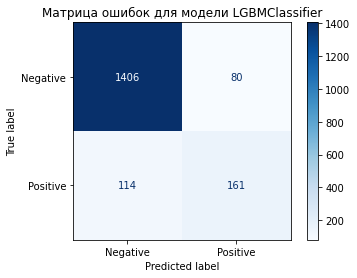

In [125]:
y_pred_lgbm = grid_search_lgbm.best_estimator_.predict(X_test_lgbm)

# Матрица ошибок
cm = confusion_matrix(y_test_lgbm, y_pred_lgbm)

# Визуализация матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок для модели LGBMClassifier')
plt.show()

Анализ матрицы ошибок показывает, что модель достаточно точно предсказывает класс 0 (горизонталь «Negative», договор не расторгнут). Из 1486 реальных случаев, когда договор не расторгнут, модель правильно классифицировала 1406 случаев, что составляет около 95%. Ошибки составляют 80 случаев, когда модель ошибочно предсказала расторжение договора, хотя договор остался активным. Для класса 1 (горизонталь «Positive», договор расторгнут) ситуация несколько хуже. Модель правильно предсказала 161 случай из 275, что составляет около 60%. Остальные 114 случаев модель ошибочно классифицировала как нерасторгнутые договора.
Получается модель очень хорошо справляется с предсказанием класса 0, но имеет небольшие трудности с правильной классификацией расторгнутых договоров.

Далее проанализируем также важность признаков для нашей лучшей модели, чтобы понять, есть ли признаки, которые не оказывают сильного влияния.

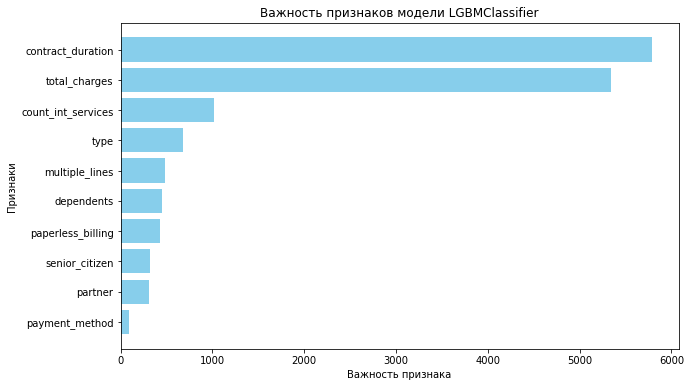

In [126]:
# Получаем важность признаков из лучшей модели
feature_importances = grid_search_lgbm.best_estimator_.feature_importances_

feature_names = X_train_lgbm.columns

# Создаем DataFrame с важностью признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность признака': feature_importances
})

# Сортируем по важности признаков
importance_df = importance_df.sort_values(by='Важность признака', ascending=False)

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Признак'], importance_df['Важность признака'], color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели LGBMClassifier')
plt.gca().invert_yaxis()
plt.show()

На основе графика, можно сказать следущее:

Наиболее значимые признаки:
1. Длительность контракта (contract_duration)
2. Общие расходы (total_charges)
3. Количество интернет услуг (count_int_services)

Менее значимые признаки:
1. Метод оплаты (payment_method)
2. Наличие супруга (partner)
3. Пожилой ли абонент (senior_citizen)

- contract_duration (длительность контракта) — Этот признак имеет наибольшую важность для модели, что говорит о том, что длительность контракта является одним из самых значимых факторов при предсказании целевой переменной. Получается продолжительность контракта может напрямую влиять на вероятность расторжения или продления контракта.
- total_charges (общие расходы) — Следующий по важности признак. Общие расходы пользователя также играют ключевую роль в предсказаниях, так как это может сигнализировать о долгосрочных отношениях с клиентом или же о его финансовой активности. 
- count_int_services (количество используемых интернет услуг) также играет важную роль, так как активные пользователи чаще остаются с компанией.

Данный анализ важности признаков помогает нам понять, какие факторы наиболее существенно влияют на модель, а какие имеют меньшее значение. Это знание можно использовать для улучшения модели, например, путем фокусировки на ключевых признаках или оптимизации обработки менее важных признаков.

Итак, можно сказать, что длительность контракта оказывает наибольшее влияние, что подсказывает важность разработки предложений для повышения лояльности новых клиентов и создания специальных условий для долгосрочных абонентов, чтобы они оставались с компанией. Суммарные и ежемесячные расходы клиентов также имеют значение, и стоит подумать о предложениях, которые помогут снизить эти расходы, не нанося ущерба прибыльности компании. В то же время, личные характеристики абонентов, такие как возраст или наличие детей или партнера, оказывают минимальное влияние, поэтому на них можно сильно не фокусироваться. 

**В данном шаге**, в ходе выбора лучшей модели для решения задачи, были протестированы несколько алгоритмов машинного обучения, включая LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и LGBMClassifier. Для каждой модели были подобраны гиперпараметры, проведена оценка метрики ROC-AUC, а также замерены время обучения и время предсказания. LGBMClassifier оказалась наилучшей моделью с наивысшей метрикой ROC-AUC (0.8631) и довольно быстрым временем предсказания, несмотря на большее время обучения. Эта модель идеально подходит для решения поставленной задачи.  Благодаря высокой точности предсказаний она может эффективно использоваться в реальных бизнес-процессах для предсказания вероятности расторжения договоров.

После тестирования модели LGBMClassifier на тестовой выборке она продемонстрировала отличные результаты:
- ROC-AUC на тестовой выборке: 0.89, что значительно превышает минимально требуемое значение 0.85 и свидетельствует о хорошей способности модели разделять классы.
- Accuracy на тестовой выборке: 0.89, что означает, что модель правильно классифицировала 89% объектов, что является также хорошим результатом.

Матрица ошибок показала, что модель точно классифицирует класс 0 (договор не расторгнут) с точностью 95%, но имеет меньшую точность для класса 1 (договор расторгнут) — около 60%. Также нами был проведён анализ важности признаков, что позволило выделить наиболее значимые факторы влияющие на прогнозируемый результат, такие как длительность контракта (contract_duration), общие расходы (total_charges) и количество интернет-услуг (count_int_services). Эти признаки оказывают наибольшее влияние на предсказания модели.

## Шаг 8. Общий вывод и рекомендации заказчику

На начальном этапе мы загрузили, выполнили анализ исходных данных и привели их к единому виду. Все данные были очищены от пропусков, и соответствующие типы данных были преобразованы для дальнейшей работы. Были устранены проблемы с типами данных, такие как преобразование признака total_charges в числовой формат, признак senior_citizen из числового типа в object, а также даты начала и окончания контракта были приведены к нужному формату. Определен целевой признак target, который указывает на уход клиента.

В ходе **анализа категориальных признаков** мы выявили интересные паттерны, а именно большинство клиентов предпочитают гибкие условия, электронные расчетные листы и избегают активации дополнительных услуг, таких как антивирус или блокировка сайтов. Кроме того, **анализ количественных признаков** показал, что большинство клиентов выбирают более дешевые и доступные тарифы, тогда как дорогие услуги выбирают немногие, что также подтверждается графиками распределения ежемесячных и общих затрат.

Затем мы объединили четыре набора информации о клиентах и провели более глубокий анализ различных признаков и их влияния на целевой признак (target). Было выявлено сильное преобладание класса 0, что указывает на дисбаланс данных: большинство клиентов продолжают пользоваться услугами, а меньшая часть прекращает. Для оценки модели выбрана метрика ROC-AUC, оптимальная при дисбалансе классов. Мы установили, что наиболее важными факторами, влияющими на уход клиентов т.е. на наш целевой признак, являются длительность контракта, общие расходы и метод оплаты. Кроме того, мы выявили мультиколлинеарность между некоторыми признаками и трансформировали или удалили избыточные данные.

Выводы анализа показали, что вероятность отказа от услуг уменьшается с увеличением срока сотрудничества: чем дольше клиент остается с компанией, тем выше его лояльность. При этом уход чаще наблюдался среди клиентов с более высокими расходами, что может быть связано с несоответствием цены и получаемой ценности услуг. Эти наблюдения подтверждают, что удержание клиентов с высокими затратами требует особого внимания, например, путем предоставления персонализированных предложений, улучшения качества обслуживания или объяснения ценности тарифов.

На основе проведенного анализа мы подготовили данные к созданию модели, которая предскажет вероятность ухода клиентов и поможет оптимизировать стратегию взаимодействия.

После подготовки данных и выполнения всех необходимых преобразований, таких как разделение на тренировочную и тестовую выборки, применение для категориальных признаков у линейных моделей One-Hot Encoding, а у древесных моделей - OrdinalEncoder(), произведения масштабирования количественных признаков, мы создали пайплайн для дальнейшей работы с данными.

На последнем этапе работы мы обучили 4 модели машинного обучения, а именно LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и LGBMClassifier.  Мы настроили их гиперпараметры с помощью кросс-валидации, замерили время обучения и предсказания. Лучшими результатами по метрике ROC-AUC (0.8631) выделилась **модель LGBMClassifier** с гиперпараметрами learning_rate=0.2 и num_leave=150, что делает ее наиболее подходящей для предсказания ухода клиентов. 

После модель LGBMClassifier показала отличные результаты и на тестовой выборке:
- ROC-AUC: 0.89, что превышает минимально допустимый порог 0.85 и подтверждает высокую способность модели различать классы.
- Accuracy: 0.89, то есть модель правильно классифицировала 89% объектов.

Кроме того, мы построили матрицу ошибок и график важности признаков. Матрица ошибок показала, что модель с высокой точностью (95%) классифицирует класс 0 (договор не расторгнут), но точность для класса 1 (договор расторгнут) составляет около 60%. Анализ важности признаков выявил наиболее значимые факторы, влияющие на предсказания: длительность контракта (contract_duration), общие расходы (total_charges) и количество интернет-услуг (count_int_services). Эти признаки оказывают наибольшее влияние на результат.

Итак, когда модель выбрана и протестирована, данные подготовлены, и благодаря ее высокой точности, она подходит для использования в реальных бизнес-процессах. Эта модель может эффективно прогнозировать вероятность расторжения договоров, позволяя бизнесу своевременно выявлять риски и принимать меры для удержания клиентов

**Рекомендации заказчику по улучшению стратегии удержания клиентов:**
- Усиление внимания на долгосрочных клиентах: Длительность контракта оказала наибольшее влияние на предсказания, поэтому важно фокусироваться на удержании новых абонентов с помощью привлекательных предложений и бонусов. Для клиентов, находящихся с компанией длительное время, стоит разработать специальные условия, которые будут стимулировать продолжение сотрудничества. Это снизит вероятность расторжения договоров и укрепит лояльность.
- Ориентированные предложения для активных пользователей: Клиенты, активно использующие интернет-услуги, требуют особого внимания для повышения их удовлетворенности и лояльности. Разработка персонализированных предложений для таких пользователей поможет снизить вероятность расторжения договоров и повысить долгосрочную ценность клиента.
- Снижение внимания к личным данным: Личные характеристики, такие как возраст или наличие детей, оказывают минимальное влияние на предсказания расторжения договоров. Это говорит о том, что компании не следует чрезмерно фокусироваться на этих аспектах при разработке стратегий удержания. Более важными являются другие факторы, такие как условия контракта и использование услуг.
- Оптимизация расходов клиентов: Суммарные и ежемесячные расходы клиента оказывают влияние на принятие решения о расторжении контракта. Для снижения финансовой нагрузки можно предложить выгодные условия или скидки, которые помогут клиентам уменьшить расходы, при этом сохраняя прибыльность компании.

Таким образом, данный проект и проделанная работа предоставляют ценную информацию для разработки эффективных стратегий удержания клиентов. Он позволяет сосредоточиться на ключевых аспектах взаимодействия с клиентами, таких как оптимизация тарифов, предложение дополнительных услуг и пересмотр условий контракта. Такой подход способствует повышению  удовлетворенности, лояльности клиентов и снижению их оттока, что напрямую влияет на стабильность и рост бизнеса